In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy, KNNBasic
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split
from tqdm import tqdm
import logging
import math
from scipy.optimize import curve_fit
import operator
from scipy.spatial.distance import jensenshannon
import json
import pickle as pickle
from itertools import chain, combinations
import sys
import heapq

In [3]:
#ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings = pd.read_csv('ml-1m-2/ratings.dat', sep="::", engine="python", names=['userId', 'movieId', 'rating', 'timestamp'])

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   userId     1000209 non-null  int64         
 1   movieId    1000209 non-null  int64         
 2   rating     1000209 non-null  int64         
 3   timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


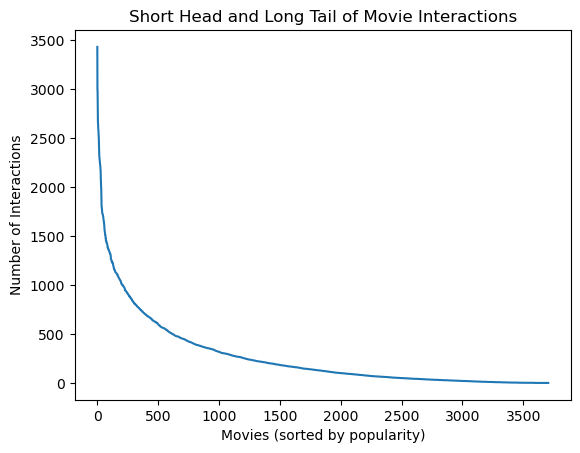

In [5]:
# Count ratings per movie and sort in descending order
movie_interactions = ratings['movieId'].value_counts().sort_values(ascending=False)

plt.plot(movie_interactions.values)
plt.title('Short Head and Long Tail of Movie Interactions')
plt.xlabel('Movies (sorted by popularity)')
plt.ylabel('Number of Interactions')
plt.show()


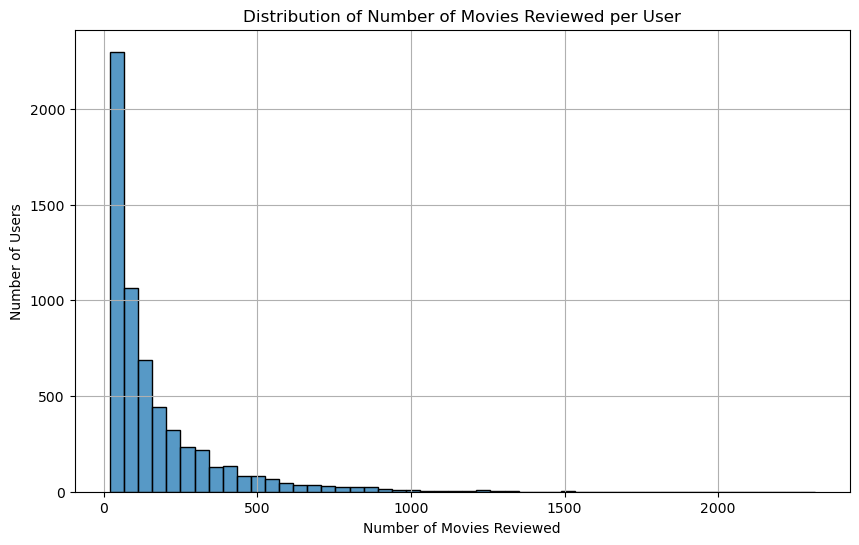

Number of users: 6040


In [6]:
user_review_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=50, kde=False)

plt.title('Distribution of Number of Movies Reviewed per User')
plt.xlabel('Number of Movies Reviewed')
plt.ylabel('Number of Users')
#plt.yscale('log') 
plt.grid(True)
plt.show()
print(f"Number of users: {ratings['userId'].nunique()}")


In [7]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Sparsity of the dataset: 0.9553


## SVD++ Model

In [8]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
        recall_avg = sum(rec for rec in recalls.values()) / len(recalls)

    return precision_avg, recall_avg

In [9]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    #array += 0.0000001
    np.add(array, 0.0000001, out=array, casting="unsafe")
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [10]:
def calculate_gini_of_recommendations(recommendation_counts):
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_counts.values()))

    # Calculate the Gini index
    gini_index = gini(recommendation_array)
    return gini_index

In [11]:
def arp_(users, recs, popularity):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        popularity_sum = 0
        for item in rec:
            p = popularity[int(item)]
            popularity_sum += p
        popularity_sum = popularity_sum/len(rec)
        users_sum += popularity_sum
    res = res * users_sum
    return res


In [12]:
def aplt(users, recs, long_tail):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        num_long_tail = len(set(long_tail).intersection(set(rec)))
        users_sum += num_long_tail/len(rec)
    res = res * users_sum
    return res

In [13]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)

def split_by_month(df, start_date, end_date):
    train_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
    test_df = df[df['timestamp'] >= end_date]

    # Ensure that the test set contains only users and items from the train set
    test_df = test_df[test_df['userId'].isin(train_df['userId']) & test_df['movieId'].isin(train_df['movieId'])]

    reader = Reader(rating_scale=(1, 5))

    train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

    trainset = train_data.build_full_trainset()

    testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))
    

    return trainset, testset, train_df, test_df

In [14]:
def evaluate_over_months(ratings, num_months):
    results = []
    recommendations = []
    train_test_sets = []
    original_recs = {}
    
    popularity = ratings['movieId'].value_counts(normalize=True).to_dict()
    max_popularity = max(popularity.values())
    popularity = {k: v / max_popularity for k, v in popularity.items()}

    long_tail_items = set(G[2])  

    start_date = ratings['timestamp'].min()

    for month_n in range(1, num_months + 1):
        end_date = start_date + pd.DateOffset(months=1)
        logging.info(f"Processing month {month_n} ({start_date.date()} to {end_date.date()})...")
        
        trainset, testset, train_df, test_df = split_by_month(ratings, start_date, end_date)
        
        train_test_sets.append((trainset, testset, train_df, test_df))
        

        model = SVD()
        logging.info(f"Starting training for month {month_n}...")
        model.fit(trainset)
        logging.info(f"Training complete for month {month_n}.")
        

        predictions = model.test(testset)

        rmse = accuracy.rmse(predictions, verbose=False)
        precision, recall = precision_recall_at_k(predictions, k=10)

        logging.info(f"month {month_n} RMSE: {rmse:.4f}")

        active_users = train_df['userId'].unique()
        candidate_items = set(train_df['movieId'].unique())

        user_rated_dict = train_df.groupby('userId')['movieId'].apply(set).to_dict()

        recs = {}

        logging.info(f"Generating recommendations for {len(active_users)} active users in month {month_n}...")
        
        for user_id in tqdm(active_users, desc=f"Recommending for month {month_n}"):

            rated_items = user_rated_dict.get(user_id, set())

            user_candidates = candidate_items - rated_items

            top_candidates = heapq.nlargest(100, user_candidates, key=lambda movie: model.predict(user_id, movie).est)

            user_recommendations = [(movie, model.predict(user_id, movie).est) for movie in top_candidates]

            top_ten = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:10]
            recs[user_id] = [movie for movie, rating in top_ten]

            recommendations.extend([(user_id, movie, rating, month_n) for movie, rating in user_recommendations])


        original_recs[month_n] = recs.copy()
        
        arp_value = arp_(active_users, recs, popularity)
        aplt_value = aplt(active_users, recs, long_tail_items)
        recommendation_count = Counter([movie_id for user_recs in recs.values() for movie_id in user_recs])
        gini_index = calculate_gini_of_recommendations(recommendation_count)

        results.append({
            'month': month_n,
            'rmse': rmse,
            'num_active_users': len(active_users),
            'precision@10': precision,
            'recall@10': recall,
            'gini_index': gini_index,
            'arp': arp_value,
            'aplt': aplt_value,
        })

        start_date = end_date

    recommendations_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'rating', 'month'])
    recommendations_df.to_csv("monthly_recommendations.csv", index=False)

    return results, recommendations_df, train_test_sets, original_recs


## Calibrated Popularity

In [15]:
def calib_rec_greedy(recs, alpha, k):
    reranked = []
    users=recs.userId.unique()

    for u in tqdm(users):
        #print("------------------------------------------------------")
        user_recs = recs.loc[recs['userId'] == u]
        user_recs = user_recs.drop_duplicates(subset=['movieId'])
        
        rating_dict = {}
        for index, row in user_recs.iterrows():
            rating_dict[row['movieId']] = row["rating"]

        #og user probabilities
        rated = UG_tolerance_map[u]

        #get all the items recommended for the user in ALS100
        items = user_recs.movieId.unique()

        T = items[:10]
        X = items[10:]

        old_list = items[:10]
        #print("User:", u, "; Original list:", old_list)
        new_list = items[:10]
        for index in range(1, 11):
            #print(index)
            #print("Old list:", old_list)
            delta = 0
            new_list = old_list.copy()
            init_cp = cp(old_list, rated, rating_dict, 0.9)
            #print("Init CP:", init_cp)
            for i in X:
                new_list[-index] = i
                new_cp = cp(new_list, rated, rating_dict, 0.9)
                #print("Item:", i, "\nNew list:", new_list, "\nCP score:", new_cp)
                if new_cp-init_cp>delta:
                    '''print("******************************")
                    print("Found better CP value!")
                    print("List:", new_list)
                    print("CP score:", new_cp)
                    print("******************************")'''
                    old_list = new_list.copy()
                    delta = new_cp-init_cp
            #print("=========================")


        #print("Best list candidate:", better_list)
        #reranked[u] = better_list
        for item in old_list:
            score = user_recs.loc[user_recs['movieId'] == item, 'rating'].item()
            #print("rating:", score)
            d = {'userId':u, 'movieId':item, 'rating':score}
            #print(d)
            reranked.append(d)

    return reranked

In [16]:
#=====================================================================
#METHODS
#method to categorize users into mainstream, niche and in-between
#takes original rating dataset as a parameter, returns a dict with user IDs and popularity group they belong to
def user_tol_cat(df):
    UG_map={}
    for u in users:
        UG1=[]
        UG2=[]
        UG3=[]
        rated=df[df.userId==u]['movieId']
        for i in rated:
            if i in G[0]:
                UG1.append(i)
            elif i in G[1]:
                UG2.append(i)
            else:
                UG3.append(i)
        UG_map[u]=[len(UG1),len(UG2),len(UG3)]

    UG_tolerance_map={}
    for u in users:
        u_g=UG_map[u]
        s=sum(u_g)
        UG_tolerance_map[u]=[float(x)/s for x in u_g]
    return UG_tolerance_map



# figure out what item index in an ordered list would be a cut-off point for a certain percentage
def find_short_head_split_point(sorted_list,percentage):
    s=0.0
    eightyPercent=float(sum(sorted_list))*percentage
    for i in range(len(sorted_list)):
        s+=sorted_list[i]
        if s>=eightyPercent:
            return i

# this method does the calculation magic - checks the relevance of the newly re-ranked list, as well as divergence between recommendation vector and user vector
def cp(recom, rated, rating_dict, alpha):

    UG_map=[len(set(G[0]).intersection(set(recom))),len(set(G[1]).intersection(set(recom))),len(set(G[2]).intersection(set(recom)))]
    UG_map = [float(x)/10 for x in UG_map]

    relevance_sum = 0
    for i in recom:
        rating = rating_dict[i]
        relevance_sum += rating

    left = (1-alpha)*relevance_sum
    j = jensenshannon(rated,UG_map)
    right = alpha*j
    res = left-right
    return res

def cali(recs100, alpha, k, month):
    print(f"Adding 'month' column for month {month}...")
    recs100['month'] = month  
    print("Checking recs100 before reranking:")
    print(recs100.head())  

    print("####### Starting the reranking...")
    reranked = calib_rec_greedy(recs100, alpha, k)
    
    # Check if reranked is a DataFrame, if not, convert it to one
    if not isinstance(reranked, pd.DataFrame):
        reranked = pd.DataFrame(reranked, columns=['userId', 'movieId', 'rating'])

    print("Checking reranked DataFrame:")
    print(reranked.head())  # Check if 'month' column is still there
    
    reranked['month'] = month  # Add the 'month' column manually here
    print("Checking reranked DataFrame after adding 'month':")
    print(reranked.head())

    reranked.to_csv(res_path, index=False)
    return reranked


In [17]:
alpha = 0.9
k = 10

# list of user IDs for utility
users = []
res_path = "svd_re-ranking"

In [18]:
# save a list of user IDs in a utility variable we have above for future use, it will come handy
users=ratings.userId.unique()

# calculate item popularities in the original rating dataset
item_pops=ratings.groupby('movieId').size()/len(ratings.userId.unique())
#item_pops.head()
item_pops_total=ratings.groupby('movieId').size()

sorted_item_pops_map = sorted(item_pops_total.items(),reverse=True,key=operator.itemgetter(1))
sorted_items=[x[0] for x in sorted_item_pops_map]
sorted_ratio=[x[1] for x in sorted_item_pops_map]

# find out where are the thresholds between head and mid items, mid and tail items
short_head_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.2)
mid_tail_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.8)

# put items into separate popularity groups
indexes=[short_head_point,mid_tail_point,len(item_pops)]
global G
G =[]
s=0
for i in range(len(indexes)):
    G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
    s=int(indexes[i])
G_names=[]
for i in range(len(G)):
    G_names.append("G%s"%(i+1))

# just double checking the lists of items with different popularites
print("Lengths of G lists:")
for l in G:
    print(len(l))

# now we can split the users into different groups based on their popularity preference too
# we will need the original rating dataset for this too
print("Calculating original user tolerance map...")
global UG_tolerance_map
UG_tolerance_map=user_tol_cat(ratings)

Lengths of G lists:
112
1069
2525
Calculating original user tolerance map...


In [19]:
# Convert to a list of tolerance distributions
tolerances = list(UG_tolerance_map.values())

# Convert to a NumPy array for easier analysis
tolerance_array = np.array(tolerances)

# Calculate mean tolerance for each category (e.g., Head, Mid, Tail)
mean_tolerance = tolerance_array.mean(axis=0)
print(f"Mean tolerance: {mean_tolerance}")

# Check variance or standard deviation
std_tolerance = tolerance_array.std(axis=0)
print(f"Standard deviation: {std_tolerance}")

Mean tolerance: [0.26824432 0.57199277 0.15976291]
Standard deviation: [0.12167725 0.09051926 0.10418744]


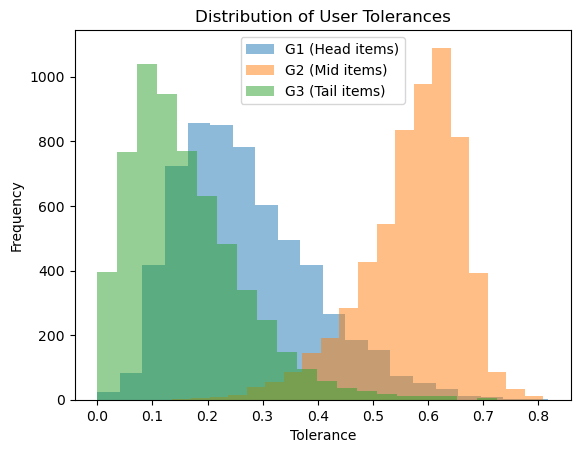

In [20]:
# Create separate lists for each category (e.g., G1, G2, G3)
g1, g2, g3 = tolerance_array.T  # Transpose to split into groups

# Plot histograms for each category
plt.hist(g1, bins=20, alpha=0.5, label="G1 (Head items)")
plt.hist(g2, bins=20, alpha=0.5, label="G2 (Mid items)")
plt.hist(g3, bins=20, alpha=0.5, label="G3 (Tail items)")

plt.title("Distribution of User Tolerances")
plt.xlabel("Tolerance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Running the model

In [21]:
if __name__ == "__main__":    
    num_months = 32
    monthly_results, recommendations_df, train_test_sets, original_recs = evaluate_over_months(ratings, num_months)

    # Loop over each month and apply CP re-ranking
    all_reranked_recommendations = []
    for month in range(1, num_months + 1):
        print(f"Processing month {month}...")
        monthly_recommendations = recommendations_df[recommendations_df['month'] == month]  # Filter recommendations for the month
        
        print(f"Checking monthly recommendations for month {month}:")
        print(monthly_recommendations.head())  # Verify 'month' column exists here

        # Apply CP re-ranking
        logging.info(f"Applying CP re-ranking for month {month}...")
        reranked_recommendations = cali(monthly_recommendations, alpha, k, month)

        # Add to the list of reranked recommendations
        all_reranked_recommendations.append(reranked_recommendations)
        
    # Combine all reranked recommendations into a single DataFrame
    reranked_df = pd.concat(all_reranked_recommendations, ignore_index=True)

    # Check if the 'month' column is preserved in the final DataFrame
    print("Checking final reranked_df:")
    print(reranked_df.head())

    reranked_df.to_csv("monthly_reranked_recommendations.csv", index=False)

    print(pd.DataFrame(monthly_results))

2025-04-28 16:39:14,140 - Processing month 1 (2000-04-25 to 2000-05-25)...
2025-04-28 16:39:14,206 - Starting training for month 1...
2025-04-28 16:39:14,554 - Training complete for month 1.
2025-04-28 16:39:14,599 - month 1 RMSE: 1.0016
2025-04-28 16:39:14,610 - Generating recommendations for 466 active users in month 1...
Recommending for month 1: 100%|██████████| 466/466 [00:02<00:00, 194.28it/s]
2025-04-28 16:39:17,033 - Processing month 2 (2000-05-25 to 2000-06-25)...
2025-04-28 16:39:17,087 - Starting training for month 2...
2025-04-28 16:39:17,314 - Training complete for month 2.
2025-04-28 16:39:17,392 - month 2 RMSE: 0.9321
2025-04-28 16:39:17,401 - Generating recommendations for 515 active users in month 2...
Recommending for month 2: 100%|██████████| 515/515 [00:02<00:00, 215.48it/s]
2025-04-28 16:39:19,799 - Processing month 3 (2000-06-25 to 2000-07-25)...
2025-04-28 16:39:19,859 - Starting training for month 3...
2025-04-28 16:39:20,174 - Training complete for month 3.
202

Processing month 1...
Checking monthly recommendations for month 1:
   userId  movieId    rating  month
0    5574     2019  4.967274      1
1    5574     2858  4.957594      1
2    5574       50  4.944291      1
3    5574     1252  4.919975      1
4    5574     2329  4.910045      1
Adding 'month' column for month 1...
Checking recs100 before reranking:
   userId  movieId    rating  month
0    5574     2019  4.967274      1
1    5574     2858  4.957594      1
2    5574       50  4.944291      1
3    5574     1252  4.919975      1
4    5574     2329  4.910045      1
####### Starting the reranking...


  6%|▋         | 30/466 [00:01<00:19, 22.49it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|██████████| 466/466 [00:20<00:00, 22.64it/s]
2025-04-28 16:40:41,984 - Applying CP re-ranking for month 2...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5574     2019  4.967274
1    5574     2858  4.957594
2    5574       50  4.944291
3    5574     1252  4.919975
4    5574     2329  4.910045
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5574     2019  4.967274      1
1    5574     2858  4.957594      1
2    5574       50  4.944291      1
3    5574     1252  4.919975      1
4    5574     2329  4.910045      1
Processing month 2...
Checking monthly recommendations for month 2:
       userId  movieId    rating  month
46600    5152     1148  4.307267      2
46601    5152     2019  4.278612      2
46602    5152      745  4.231290      2
46603    5152     1243  4.114007      2
46604    5152     1090  4.098266      2
Adding 'month' column for month 2...
Checking recs100 before reranking:
       userId  movieId    rating  month
46600    5152     1148  4.307267      2
46601    5152     2019  4.278612      2
46602    5152      745  4.23129

100%|██████████| 515/515 [00:22<00:00, 22.60it/s]
2025-04-28 16:41:04,798 - Applying CP re-ranking for month 3...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5152     1148  4.307267
1    5152     2019  4.278612
2    5152      745  4.231290
3    5152     1243  4.114007
4    5152     1090  4.098266
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5152     1148  4.307267      2
1    5152     2019  4.278612      2
2    5152      745  4.231290      2
3    5152     1243  4.114007      2
4    5152     1090  4.098266      2
Processing month 3...
Checking monthly recommendations for month 3:
       userId  movieId    rating  month
98100    4551     1148  4.872744      3
98101    4551      745  4.735405      3
98102    4551     1254  4.732825      3
98103    4551      922  4.710655      3
98104    4551     3022  4.681674      3
Adding 'month' column for month 3...
Checking recs100 before reranking:
       userId  movieId    rating  month
98100    4551     1148  4.872744      3
98101    4551      745  4.735405      3
98102    4551     1254  4.73282

100%|██████████| 733/733 [00:32<00:00, 22.46it/s]
2025-04-28 16:41:37,462 - Applying CP re-ranking for month 4...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4551     1148  4.872744
1    4551      745  4.735405
2    4551     1254  4.732825
3    4551      922  4.710655
4    4551     3022  4.681674
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4551     1148  4.872744      3
1    4551      745  4.735405      3
2    4551     1254  4.732825      3
3    4551      922  4.710655      3
4    4551     3022  4.681674      3
Processing month 4...
Checking monthly recommendations for month 4:
        userId  movieId    rating  month
171400    3450     3421  4.754886      4
171401    3450       50  4.743711      4
171402    3450      593  4.642313      4
171403    3450     3671  4.600225      4
171404    3450      922  4.582450      4
Adding 'month' column for month 4...
Checking recs100 before reranking:
        userId  movieId    rating  month
171400    3450     3421  4.754886      4
171401    3450       50  4.743711      4
171402    3450      59

 30%|███       | 387/1284 [00:17<00:40, 22.01it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|██████████| 1284/1284 [00:56<00:00, 22.72it/s]
2025-04-28 16:42:34,017 - Applying CP re-ranking for month 5...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3450     3421  4.754886
1    3450       50  4.743711
2    3450      593  4.642313
3    3450     3671  4.600225
4    3450      922  4.582450
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3450     3421  4.754886      4
1    3450       50  4.743711      4
2    3450      593  4.642313      4
3    3450     3671  4.600225      4
4    3450      922  4.582450      4
Processing month 5...
Checking monthly recommendations for month 5:
        userId  movieId    rating  month
299800    3075     2762  4.505020      5
299801    3075     1203  4.429713      5
299802    3075     1250  4.331425      5
299803    3075     3578  4.290157      5
299804    3075      720  4.260773      5
Adding 'month' column for month 5...
Checking recs100 before reranking:
        userId  movieId    rating  month
299800    3075     2762  4.505020      5
299801    3075     1203  4.429713      5
299802    3075     125

100%|██████████| 650/650 [00:28<00:00, 22.70it/s]
2025-04-28 16:43:02,678 - Applying CP re-ranking for month 6...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3075     2762  4.505020
1    3075     1203  4.429713
2    3075     1250  4.331425
3    3075     3578  4.290157
4    3075      720  4.260773
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3075     2762  4.505020      5
1    3075     1203  4.429713      5
2    3075     1250  4.331425      5
3    3075     3578  4.290157      5
4    3075      720  4.260773      5
Processing month 6...
Checking monthly recommendations for month 6:
        userId  movieId    rating  month
364800    2848     3147  4.397687      6
364801    2848      912  4.384369      6
364802    2848     1221  4.375370      6
364803    2848     3114  4.321458      6
364804    2848     1287  4.279027      6
Adding 'month' column for month 6...
Checking recs100 before reranking:
        userId  movieId    rating  month
364800    2848     3147  4.397687      6
364801    2848      912  4.384369      6
364802    2848     122

100%|██████████| 482/482 [00:21<00:00, 22.59it/s]
2025-04-28 16:43:24,037 - Applying CP re-ranking for month 7...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2848     3147  4.397687
1    2848      912  4.384369
2    2848     1221  4.375370
3    2848     3114  4.321458
4    2848     1287  4.279027
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2848     3147  4.397687      6
1    2848      912  4.384369      6
2    2848     1221  4.375370      6
3    2848     3114  4.321458      6
4    2848     1287  4.279027      6
Processing month 7...
Checking monthly recommendations for month 7:
        userId  movieId    rating  month
413000     928      296  5.000000      7
413001     928      318  4.922283      7
413002     928       50  4.911442      7
413003     928     2396  4.903523      7
413004     928     3949  4.884359      7
Adding 'month' column for month 7...
Checking recs100 before reranking:
        userId  movieId    rating  month
413000     928      296  5.000000      7
413001     928      318  4.922283      7
413002     928       5

  5%|▌         | 114/2141 [00:04<01:27, 23.19it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|██████████| 2141/2141 [01:32<00:00, 23.04it/s]
2025-04-28 16:44:57,045 - Applying CP re-ranking for month 8...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     928      296  5.000000
1     928      318  4.922283
2     928     1178  4.827756
3     928     2019  4.791850
4     928     3949  4.884359
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     928      296  5.000000      7
1     928      318  4.922283      7
2     928     1178  4.827756      7
3     928     2019  4.791850      7
4     928     3949  4.884359      7
Processing month 8...
Checking monthly recommendations for month 8:
        userId  movieId    rating  month
627100      81      318  5.000000      8
627101      81     1136  5.000000      8
627102      81     1178  4.995014      8
627103      81     1148  4.993917      8
627104      81      246  4.959934      8
Adding 'month' column for month 8...
Checking recs100 before reranking:
        userId  movieId    rating  month
627100      81      318  5.000000      8
627101      81     1136  5.000000      8
627102      81     117

 33%|███▎      | 477/1436 [00:20<00:40, 23.70it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|██████████| 1436/1436 [01:02<00:00, 22.93it/s]
2025-04-28 16:45:59,725 - Applying CP re-ranking for month 9...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      81      318  5.000000
1      81     1136  5.000000
2      81     1178  4.995014
3      81     1148  4.993917
4      81      246  4.959934
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      81      318  5.000000      8
1      81     1136  5.000000      8
2      81     1178  4.995014      8
3      81     1148  4.993917      8
4      81      246  4.959934      8
Processing month 9...
Checking monthly recommendations for month 9:
        userId  movieId    rating  month
770700       1     1198  5.000000      9
770701       1     1234  4.974127      9
770702       1      899  4.677197      9
770703       1      858  4.673958      9
770704       1     1278  4.657606      9
Adding 'month' column for month 9...
Checking recs100 before reranking:
        userId  movieId    rating  month
770700       1     1198  5.000000      9
770701       1     1234  4.974127      9
770702       1      89

100%|██████████| 633/633 [00:27<00:00, 22.89it/s]
2025-04-28 16:46:27,403 - Applying CP re-ranking for month 10...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0       1     1198  5.000000
1       1     1234  4.974127
2       1      899  4.677197
3       1      858  4.673958
4       1     1278  4.657606
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0       1     1198  5.000000      9
1       1     1234  4.974127      9
2       1      899  4.677197      9
3       1      858  4.673958      9
4       1     1278  4.657606      9
Processing month 10...
Checking monthly recommendations for month 10:
        userId  movieId    rating  month
834000      10      858  4.663245     10
834001      10     2858  4.642626     10
834002      10      608  4.629091     10
834003      10     3510  4.594748     10
834004      10      318  4.538353     10
Adding 'month' column for month 10...
Checking recs100 before reranking:
        userId  movieId    rating  month
834000      10      858  4.663245     10
834001      10     2858  4.642626     10
834002      10     

100%|██████████| 429/429 [00:18<00:00, 22.78it/s]
2025-04-28 16:46:46,258 - Applying CP re-ranking for month 11...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      10      858  4.663245
1      10     2858  4.642626
2      10     2194  4.474233
3      10     3510  4.594748
4      10     2268  4.432981
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      10      858  4.663245     10
1      10     2858  4.642626     10
2      10     2194  4.474233     10
3      10     3510  4.594748     10
4      10     2268  4.432981     10
Processing month 11...
Checking monthly recommendations for month 11:
        userId  movieId    rating  month
876900      36      904  4.533786     11
876901      36     3317  4.412377     11
876902      36     1200  4.346571     11
876903      36      318  4.313735     11
876904      36     3481  4.311421     11
Adding 'month' column for month 11...
Checking recs100 before reranking:
        userId  movieId    rating  month
876900      36      904  4.533786     11
876901      36     3317  4.412377     11
876902      36     

100%|██████████| 315/315 [00:13<00:00, 22.77it/s]
2025-04-28 16:47:00,108 - Applying CP re-ranking for month 12...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      36      904  4.533786
1      36     3317  4.412377
2      36     1200  4.346571
3      36      318  4.313735
4      36     3897  4.208162
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36      904  4.533786     11
1      36     3317  4.412377     11
2      36     1200  4.346571     11
3      36      318  4.313735     11
4      36     3897  4.208162     11
Processing month 12...
Checking monthly recommendations for month 12:
        userId  movieId    rating  month
908400      24     3916  4.439760     12
908401      24      904  4.397701     12
908402      24     1203  4.389066     12
908403      24     2804  4.369132     12
908404      24      930  4.304285     12
Adding 'month' column for month 12...
Checking recs100 before reranking:
        userId  movieId    rating  month
908400      24     3916  4.439760     12
908401      24      904  4.397701     12
908402      24     

100%|██████████| 307/307 [00:13<00:00, 22.91it/s]
2025-04-28 16:47:13,525 - Applying CP re-ranking for month 13...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      24     3916  4.439760
1      24      904  4.397701
2      24     1203  4.389066
3      24     2804  4.369132
4      24      930  4.304285
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      24     3916  4.439760     12
1      24      904  4.397701     12
2      24     1203  4.389066     12
3      24     2804  4.369132     12
4      24      930  4.304285     12
Processing month 13...
Checking monthly recommendations for month 13:
        userId  movieId    rating  month
939100      65     3897  4.452631     13
939101      65      903  4.187389     13
939102      65      296  4.153021     13
939103      65     2762  4.148179     13
939104      65     1597  4.126170     13
Adding 'month' column for month 13...
Checking recs100 before reranking:
        userId  movieId    rating  month
939100      65     3897  4.452631     13
939101      65      903  4.187389     13
939102      65     

100%|██████████| 254/254 [00:11<00:00, 22.94it/s]
2025-04-28 16:47:24,611 - Applying CP re-ranking for month 14...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65     3897  4.452631
1      65      903  4.187389
2      65      296  4.153021
3      65     2762  4.148179
4      65     1597  4.126170
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65     3897  4.452631     13
1      65      903  4.187389     13
2      65      296  4.153021     13
3      65     2762  4.148179     13
4      65     1597  4.126170     13
Processing month 14...
Checking monthly recommendations for month 14:
        userId  movieId    rating  month
964500      22     2028  4.343289     14
964501      22     2245  4.285557     14
964502      22      858  4.228046     14
964503      22      593  4.203915     14
964504      22      150  4.192907     14
Adding 'month' column for month 14...
Checking recs100 before reranking:
        userId  movieId    rating  month
964500      22     2028  4.343289     14
964501      22     2245  4.285557     14
964502      22     

100%|██████████| 294/294 [00:12<00:00, 22.78it/s]
2025-04-28 16:47:37,532 - Applying CP re-ranking for month 15...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      22     2028  4.343289
1      22     2245  4.285557
2      22      858  4.228046
3      22     2268  4.107978
4      22      150  4.192907
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      22     2028  4.343289     14
1      22     2245  4.285557     14
2      22      858  4.228046     14
3      22     2268  4.107978     14
4      22      150  4.192907     14
Processing month 15...
Checking monthly recommendations for month 15:
        userId  movieId    rating  month
993900      19     3949  4.201960     15
993901      19       50  4.182008     15
993902      19     1954  4.167587     15
993903      19     1639  4.156323     15
993904      19      150  4.133020     15
Adding 'month' column for month 15...
Checking recs100 before reranking:
        userId  movieId    rating  month
993900      19     3949  4.201960     15
993901      19       50  4.182008     15
993902      19     

100%|██████████| 288/288 [00:12<00:00, 23.02it/s]
2025-04-28 16:47:50,054 - Applying CP re-ranking for month 16...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      19     3949  4.201960
1      19       50  4.182008
2      19     1954  4.167587
3      19     1639  4.156323
4      19      150  4.133020
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      19     3949  4.201960     15
1      19       50  4.182008     15
2      19     1954  4.167587     15
3      19     1639  4.156323     15
4      19      150  4.133020     15
Processing month 16...
Checking monthly recommendations for month 16:
         userId  movieId    rating  month
1022700     116     1136  4.410860     16
1022701     116     2762  4.334282     16
1022702     116      527  4.317974     16
1022703     116      858  4.230628     16
1022704     116     2959  4.216416     16
Adding 'month' column for month 16...
Checking recs100 before reranking:
         userId  movieId    rating  month
1022700     116     1136  4.410860     16
1022701     116     2762  4.334282     16
1022702   

100%|██████████| 259/259 [00:11<00:00, 23.02it/s]
2025-04-28 16:48:01,319 - Applying CP re-ranking for month 17...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     116     1136  4.410860
1     116     2762  4.334282
2     116     2529  4.134618
3     116     1218  3.974005
4     116     3160  4.136457
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     116     1136  4.410860     16
1     116     2762  4.334282     16
2     116     2529  4.134618     16
3     116     1218  3.974005     16
4     116     3160  4.136457     16
Processing month 17...
Checking monthly recommendations for month 17:
         userId  movieId    rating  month
1048600      65      593  4.197208     17
1048601      65     2959  4.136779     17
1048602      65     1639  4.126036     17
1048603      65     1235  4.020495     17
1048604      65      296  3.996399     17
Adding 'month' column for month 17...
Checking recs100 before reranking:
         userId  movieId    rating  month
1048600      65      593  4.197208     17
1048601      65     2959  4.136779     17
1048602   

100%|██████████| 204/204 [00:08<00:00, 22.72it/s]
2025-04-28 16:48:10,310 - Applying CP re-ranking for month 18...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65      593  4.197208
1      65     2959  4.136779
2      65     1639  4.126036
3      65     1235  4.020495
4      65      296  3.996399
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65      593  4.197208     17
1      65     2959  4.136779     17
2      65     1639  4.126036     17
3      65     1235  4.020495     17
4      65      296  3.996399     17
Processing month 18...
Checking monthly recommendations for month 18:
         userId  movieId    rating  month
1069000     102     3783  3.712886     18
1069001     102     1704  3.676672     18
1069002     102     1210  3.587611     18
1069003     102     2289  3.577841     18
1069004     102     3916  3.576905     18
Adding 'month' column for month 18...
Checking recs100 before reranking:
         userId  movieId    rating  month
1069000     102     3783  3.712886     18
1069001     102     1704  3.676672     18
1069002   

100%|██████████| 175/175 [00:07<00:00, 22.93it/s]
2025-04-28 16:48:17,953 - Applying CP re-ranking for month 19...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     102     3783  3.712886
1     102     1704  3.676672
2     102     1210  3.587611
3     102     2289  3.577841
4     102     3916  3.576905
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     102     3783  3.712886     18
1     102     1704  3.676672     18
2     102     1210  3.587611     18
3     102     2289  3.577841     18
4     102     3916  3.576905     18
Processing month 19...
Checking monthly recommendations for month 19:
         userId  movieId    rating  month
1086500      44      923  4.122181     19
1086501      44      858  3.944406     19
1086502      44     1136  3.839060     19
1086503      44      527  3.756734     19
1086504      44      593  3.749472     19
Adding 'month' column for month 19...
Checking recs100 before reranking:
         userId  movieId    rating  month
1086500      44      923  4.122181     19
1086501      44      858  3.944406     19
1086502   

100%|██████████| 190/190 [00:08<00:00, 22.84it/s]
2025-04-28 16:48:26,282 - Applying CP re-ranking for month 20...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      44      923  4.122181
1      44      858  3.944406
2      44     1136  3.839060
3      44      527  3.756734
4      44     3719  3.532293
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      44      923  4.122181     19
1      44      858  3.944406     19
2      44     1136  3.839060     19
3      44      527  3.756734     19
4      44     3719  3.532293     19
Processing month 20...
Checking monthly recommendations for month 20:
         userId  movieId    rating  month
1105500     127     3897  4.106565     20
1105501     127     2571  4.086887     20
1105502     127     1210  3.977388     20
1105503     127     1283  3.975896     20
1105504     127     1221  3.966718     20
Adding 'month' column for month 20...
Checking recs100 before reranking:
         userId  movieId    rating  month
1105500     127     3897  4.106565     20
1105501     127     2571  4.086887     20
1105502   

100%|██████████| 174/174 [00:07<00:00, 23.08it/s]
2025-04-28 16:48:33,832 - Applying CP re-ranking for month 21...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     127     3897  4.106565
1     127     2571  4.086887
2     127     1210  3.977388
3     127     1283  3.975896
4     127     1221  3.966718
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     127     3897  4.106565     20
1     127     2571  4.086887     20
2     127     1210  3.977388     20
3     127     1283  3.975896     20
4     127     1221  3.966718     20
Processing month 21...
Checking monthly recommendations for month 21:
         userId  movieId    rating  month
1122900      20     1198  4.405396     21
1122901      20     2959  4.346809     21
1122902      20     3578  4.306012     21
1122903      20     1945  4.269721     21
1122904      20     1221  4.151697     21
Adding 'month' column for month 21...
Checking recs100 before reranking:
         userId  movieId    rating  month
1122900      20     1198  4.405396     21
1122901      20     2959  4.346809     21
1122902   

100%|██████████| 228/228 [00:09<00:00, 22.86it/s]
2025-04-28 16:48:43,817 - Applying CP re-ranking for month 22...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      20     1198  4.405396
1      20     2959  4.346809
2      20     3578  4.306012
3      20     1945  4.269721
4      20     1221  4.151697
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      20     1198  4.405396     21
1      20     2959  4.346809     21
2      20     3578  4.306012     21
3      20     1945  4.269721     21
4      20     1221  4.151697     21
Processing month 22...
Checking monthly recommendations for month 22:
         userId  movieId    rating  month
1145700      36     1206  4.283665     22
1145701      36     2692  4.250775     22
1145702      36      858  4.247951     22
1145703      36     3911  4.211212     22
1145704      36      924  4.207115     22
Adding 'month' column for month 22...
Checking recs100 before reranking:
         userId  movieId    rating  month
1145700      36     1206  4.283665     22
1145701      36     2692  4.250775     22
1145702   

100%|██████████| 196/196 [00:08<00:00, 22.97it/s]
2025-04-28 16:48:52,362 - Applying CP re-ranking for month 23...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      36     1206  4.283665
1      36     2692  4.250775
2      36      858  4.247951
3      36     3911  4.211212
4      36      924  4.207115
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36     1206  4.283665     22
1      36     2692  4.250775     22
2      36      858  4.247951     22
3      36     3911  4.211212     22
4      36      924  4.207115     22
Processing month 23...
Checking monthly recommendations for month 23:
         userId  movieId    rating  month
1165300      36      593  4.670221     23
1165301      36     2160  4.561230     23
1165302      36     1827  4.548515     23
1165303      36     1292  4.539103     23
1165304      36     2858  4.508699     23
Adding 'month' column for month 23...
Checking recs100 before reranking:
         userId  movieId    rating  month
1165300      36      593  4.670221     23
1165301      36     2160  4.561230     23
1165302   

100%|██████████| 160/160 [00:06<00:00, 23.20it/s]
2025-04-28 16:48:59,269 - Applying CP re-ranking for month 24...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      36      593  4.670221
1      36     2160  4.561230
2      36     1827  4.548515
3      36     1292  4.539103
4      36     2858  4.508699
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36      593  4.670221     23
1      36     2160  4.561230     23
2      36     1827  4.548515     23
3      36     1292  4.539103     23
4      36     2858  4.508699     23
Processing month 24...
Checking monthly recommendations for month 24:
         userId  movieId    rating  month
1181300      65     3911  4.237113     24
1181301      65     2470  4.051934     24
1181302      65     1954  4.015559     24
1181303      65     1394  4.010115     24
1181304      65     1682  3.999508     24
Adding 'month' column for month 24...
Checking recs100 before reranking:
         userId  movieId    rating  month
1181300      65     3911  4.237113     24
1181301      65     2470  4.051934     24
1181302   

100%|██████████| 146/146 [00:06<00:00, 23.06it/s]
2025-04-28 16:49:05,611 - Applying CP re-ranking for month 25...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65     3911  4.237113
1      65     2470  4.051934
2      65     1954  4.015559
3      65     1394  4.010115
4      65     1682  3.999508
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65     3911  4.237113     24
1      65     2470  4.051934     24
2      65     1954  4.015559     24
3      65     1394  4.010115     24
4      65     1682  3.999508     24
Processing month 25...
Checking monthly recommendations for month 25:
         userId  movieId    rating  month
1195900     134       50  4.497879     25
1195901     134     1208  4.211572     25
1195902     134     1267  4.205496     25
1195903     134     1036  4.136312     25
1195904     134     2248  4.135526     25
Adding 'month' column for month 25...
Checking recs100 before reranking:
         userId  movieId    rating  month
1195900     134       50  4.497879     25
1195901     134     1208  4.211572     25
1195902   

100%|██████████| 151/151 [00:06<00:00, 23.25it/s]
2025-04-28 16:49:12,117 - Applying CP re-ranking for month 26...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     134       50  4.497879
1     134     1208  4.211572
2     134     1267  4.205496
3     134     1036  4.136312
4     134     2248  4.135526
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     134       50  4.497879     25
1     134     1208  4.211572     25
2     134     1267  4.205496     25
3     134     1036  4.136312     25
4     134     2248  4.135526     25
Processing month 26...
Checking monthly recommendations for month 26:
         userId  movieId    rating  month
1211000      65      224  4.093389     26
1211001      65     1225  4.093339     26
1211002      65     1081  4.065495     26
1211003      65     1639  4.057091     26
1211004      65     2690  4.006417     26
Adding 'month' column for month 26...
Checking recs100 before reranking:
         userId  movieId    rating  month
1211000      65      224  4.093389     26
1211001      65     1225  4.093339     26
1211002   

100%|██████████| 154/154 [00:06<00:00, 23.17it/s]
2025-04-28 16:49:18,775 - Applying CP re-ranking for month 27...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65      224  4.093389
1      65     1225  4.093339
2      65     1081  4.065495
3      65     1639  4.057091
4      65     2690  4.006417
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65      224  4.093389     26
1      65     1225  4.093339     26
2      65     1081  4.065495     26
3      65     1639  4.057091     26
4      65     2690  4.006417     26
Processing month 27...
Checking monthly recommendations for month 27:
         userId  movieId    rating  month
1226400     146     3683  3.855469     27
1226401     146      150  3.757020     27
1226402     146      903  3.746485     27
1226403     146     2081  3.741797     27
1226404     146     2920  3.733040     27
Adding 'month' column for month 27...
Checking recs100 before reranking:
         userId  movieId    rating  month
1226400     146     3683  3.855469     27
1226401     146      150  3.757020     27
1226402   

100%|██████████| 155/155 [00:06<00:00, 23.30it/s]
2025-04-28 16:49:25,438 - Applying CP re-ranking for month 28...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     146     3683  3.855469
1     146      150  3.757020
2     146      903  3.746485
3     146     2081  3.741797
4     146     2920  3.733040
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     146     3683  3.855469     27
1     146      150  3.757020     27
2     146      903  3.746485     27
3     146     2081  3.741797     27
4     146     2920  3.733040     27
Processing month 28...
Checking monthly recommendations for month 28:
         userId  movieId    rating  month
1241900      65      260  3.839897     28
1241901      65     1266  3.736023     28
1241902      65     3408  3.695360     28
1241903      65      527  3.650433     28
1241904      65     3949  3.627086     28
Adding 'month' column for month 28...
Checking recs100 before reranking:
         userId  movieId    rating  month
1241900      65      260  3.839897     28
1241901      65     1266  3.736023     28
1241902   

100%|██████████| 143/143 [00:06<00:00, 23.42it/s]
2025-04-28 16:49:31,553 - Applying CP re-ranking for month 29...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65      260  3.839897
1      65     1266  3.736023
2      65     3408  3.695360
3      65      527  3.650433
4      65     3949  3.627086
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65      260  3.839897     28
1      65     1266  3.736023     28
2      65     3408  3.695360     28
3      65      527  3.650433     28
4      65     3949  3.627086     28
Processing month 29...
Checking monthly recommendations for month 29:
         userId  movieId    rating  month
1256200     164     1193  4.031087     29
1256201     164     1198  4.004299     29
1256202     164     1253  3.946772     29
1256203     164     1678  3.938483     29
1256204     164     1617  3.934514     29
Adding 'month' column for month 29...
Checking recs100 before reranking:
         userId  movieId    rating  month
1256200     164     1193  4.031087     29
1256201     164     1198  4.004299     29
1256202   

100%|██████████| 115/115 [00:04<00:00, 23.35it/s]
2025-04-28 16:49:36,486 - Applying CP re-ranking for month 30...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     164     1193  4.031087
1     164     1198  4.004299
2     164     1253  3.946772
3     164     1678  3.938483
4     164     1212  3.918387
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     164     1193  4.031087     29
1     164     1198  4.004299     29
2     164     1253  3.946772     29
3     164     1678  3.938483     29
4     164     1212  3.918387     29
Processing month 30...
Checking monthly recommendations for month 30:
         userId  movieId    rating  month
1267700      65     1211  4.065455     30
1267701      65      913  4.059101     30
1267702      65     2746  4.034541     30
1267703      65     1043  4.030710     30
1267704      65     1954  4.030628     30
Adding 'month' column for month 30...
Checking recs100 before reranking:
         userId  movieId    rating  month
1267700      65     1211  4.065455     30
1267701      65      913  4.059101     30
1267702   

100%|██████████| 118/118 [00:05<00:00, 23.03it/s]
2025-04-28 16:49:41,617 - Applying CP re-ranking for month 31...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      65     1211  4.065455
1      65      913  4.059101
2      65     2746  4.034541
3      65     2348  3.986467
4      65     1954  4.030628
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      65     1211  4.065455     30
1      65      913  4.059101     30
2      65     2746  4.034541     30
3      65     2348  3.986467     30
4      65     1954  4.030628     30
Processing month 31...
Checking monthly recommendations for month 31:
         userId  movieId    rating  month
1279500     169     2357  4.080873     31
1279501     169      923  4.010276     31
1279502     169     2019  4.001442     31
1279503     169     1172  3.989981     31
1279504     169      904  3.979199     31
Adding 'month' column for month 31...
Checking recs100 before reranking:
         userId  movieId    rating  month
1279500     169     2357  4.080873     31
1279501     169      923  4.010276     31
1279502   

100%|██████████| 131/131 [00:05<00:00, 23.54it/s]
2025-04-28 16:49:47,189 - Applying CP re-ranking for month 32...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_29062/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     169     2357  4.080873
1     169      923  4.010276
2     169     2019  4.001442
3     169     1172  3.989981
4     169      904  3.979199
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     169     2357  4.080873     31
1     169      923  4.010276     31
2     169     2019  4.001442     31
3     169     1172  3.989981     31
4     169      904  3.979199     31
Processing month 32...
Checking monthly recommendations for month 32:
         userId  movieId    rating  month
1292600      36     2393  4.262035     32
1292601      36      923  4.192731     32
1292602      36     3949  4.190612     32
1292603      36     1193  4.184104     32
1292604      36     3706  4.176426     32
Adding 'month' column for month 32...
Checking recs100 before reranking:
         userId  movieId    rating  month
1292600      36     2393  4.262035     32
1292601      36      923  4.192731     32
1292602   

100%|██████████| 119/119 [00:05<00:00, 23.43it/s]


Checking reranked DataFrame:
   userId  movieId    rating
0      36     2393  4.262035
1      36      923  4.192731
2      36     3949  4.190612
3      36     1193  4.184104
4      36     3706  4.176426
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      36     2393  4.262035     32
1      36      923  4.192731     32
2      36     3949  4.190612     32
3      36     1193  4.184104     32
4      36     3706  4.176426     32
Checking final reranked_df:
   userId  movieId    rating  month
0    5574     2019  4.967274      1
1    5574     2858  4.957594      1
2    5574       50  4.944291      1
3    5574     1252  4.919975      1
4    5574     2329  4.910045      1
    month      rmse  num_active_users  precision@10  recall@10  gini_index  \
0       1  1.001613               466      0.783424   0.405215    0.755956   
1       2  0.932127               515      0.714977   0.372005    0.746898   
2       3  0.944506               733      0.752863  

In [22]:
for result in monthly_results:
    print(f"month {result['month']}: RMSE = {result['rmse']:.4f} - Precision@10: {result['precision@10']:.4f}, "
          f"Recall@10: {result['recall@10']:.4f}, Active Users = {result['num_active_users']}, "
          f"Gini Index of Recommendations = {result['gini_index']:.4f}, "
          f"ARP = {result['arp']:.4f}, "
          f"APLT = {result['aplt']:.4f}") 

month 1: RMSE = 1.0016 - Precision@10: 0.7834, Recall@10: 0.4052, Active Users = 466, Gini Index of Recommendations = 0.7560, ARP = 0.3104, APLT = 0.0423
month 2: RMSE = 0.9321 - Precision@10: 0.7150, Recall@10: 0.3720, Active Users = 515, Gini Index of Recommendations = 0.7469, ARP = 0.3377, APLT = 0.0200
month 3: RMSE = 0.9445 - Precision@10: 0.7529, Recall@10: 0.3913, Active Users = 733, Gini Index of Recommendations = 0.8131, ARP = 0.3021, APLT = 0.0849
month 4: RMSE = 0.9941 - Precision@10: 0.7352, Recall@10: 0.3569, Active Users = 1284, Gini Index of Recommendations = 0.7956, ARP = 0.3227, APLT = 0.1116
month 5: RMSE = 0.9431 - Precision@10: 0.7305, Recall@10: 0.3899, Active Users = 650, Gini Index of Recommendations = 0.7771, ARP = 0.3945, APLT = 0.0194
month 6: RMSE = 0.9596 - Precision@10: 0.7395, Recall@10: 0.3746, Active Users = 482, Gini Index of Recommendations = 0.7617, ARP = 0.4749, APLT = 0.0025
month 7: RMSE = 0.9232 - Precision@10: 0.7628, Recall@10: 0.3494, Active Us

## Metrics for re-ranking technique

In [23]:
def calculate_gini_of_recommendations_cp(movie_ids):
    # Count the number of recommendations for each movie
    recommendation_count = Counter(movie_ids)
    #recommendation_count = Counter([pred.iid for pred in movie_ids])
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [24]:
def calculate_arp(reranked_df, item_popularity):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute ARP using the provided function
    arp_value = arp_(users, recs, item_popularity)
    return arp_value

In [25]:
def calculate_aplt(reranked_df, long_tail_items):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    aplt_value = aplt(users, recs, long_tail_items)
    return aplt_value

In [26]:
item_popularity = reranked_df['movieId'].value_counts(normalize=True).to_dict()

In [27]:
max_popularity = max(item_popularity.values())
item_popularity = {k: v / max_popularity for k, v in item_popularity.items()}
long_tail_items = set(G[2])

In [28]:
results = []
monthly_data = {month: month_data for month, month_data in reranked_df.groupby('month')}

for month, month_data in monthly_data.items():
    movie_ids = month_data['movieId'].tolist()
    gini_index = calculate_gini_of_recommendations_cp(movie_ids)
    monthly_arp = calculate_arp(month_data, item_popularity)
    monthly_aplt = calculate_aplt(month_data, long_tail_items)
    
    _, testset, _, _ = train_test_sets[month - 1]
    # Create a lookup dictionary for test ratings: keys are (user, movie)
    test_ratings = {(user, movie): rating for (user, movie, rating) in testset}
    
    # Restrict evaluation to users present in the test set.
    test_users = {user for (user, movie, rating) in testset}
    
    cp_predictions = []
    
    # Loop over only those users that appear in the test set
    for user in test_users:
        # Get the CP recommendations for this user in the current month
        user_cp_recs = month_data[month_data['userId'] == user]
        if user_cp_recs.empty:
            continue
        # Sort the user's CP recommendations by rating in descending order and take the top 10
        top10 = user_cp_recs.sort_values(by='rating', ascending=False).head(10)
        # For each recommended movie in the top10, if it exists in the test set, form a prediction tuple
        for _, row in top10.iterrows():
            movie = int(row['movieId'])  # Ensure the type matches
            predicted_rating = row['rating']
            if (user, movie) in test_ratings:
                true_rating = test_ratings[(user, movie)]
                cp_predictions.append((user, movie, true_rating, predicted_rating, None))
    
    if not cp_predictions:
        print(f"Warning: No CP predictions matched the test set for month {month}!")
        rmse, precision, recall = float('nan'), float('nan'), float('nan')
    else:
        rmse = accuracy.rmse(cp_predictions, verbose=False)
        precision, recall = precision_recall_at_k(cp_predictions, k=10)
    
    results.append({
        "month": month,
        "gini_index": gini_index,
        "arp": monthly_arp,
        "aplt": monthly_aplt,
        "rmse": rmse,
        "precision@10": precision,
        "recall@10": recall
    })

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("beyond_accuracy_per_month.csv", index=False)

    month  gini_index       arp      aplt      rmse  precision@10  recall@10
0       1    0.745269  0.328580  0.150858  0.920087      0.840769   0.907692
1       2    0.727930  0.341237  0.151068  0.709393      0.907675   0.960526
2       3    0.803282  0.390797  0.163029  0.772145      0.880921   0.938596
3       4    0.789492  0.316898  0.166900  0.975331      0.824969   0.907895
4       5    0.770342  0.364299  0.158154  0.796265      0.879630   0.933333
5       6    0.769687  0.299794  0.147925  0.934682      0.798045   0.880734
6       7    0.811339  0.346024  0.164876  0.785241      0.882749   0.941333
7       8    0.808274  0.398844  0.163092  0.870682      0.857056   0.904215
8       9    0.780738  0.267227  0.133965  0.813969      0.811508   0.872222
9      10    0.760781  0.245667  0.167599  0.895525      0.735611   0.807453
10     11    0.796681  0.327786  0.177778  0.789149      0.810897   0.891026
11     12    0.802495  0.231526  0.183713  0.808169      0.785404   0.845890

## Explorative Analysis

In [29]:
short_head_items = set(G[0])  
mid_items = set(G[1])         
long_tail_items = set(G[2])   


print("Short Head Items:", len(short_head_items))
print("Mid Items:", len(mid_items))
print("Long Tail Items:", len(long_tail_items))

Short Head Items: 112
Mid Items: 1069
Long Tail Items: 2525


In [30]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in reranked_df['month'].unique():
    month_data = reranked_df[reranked_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 1
        elif movie_id in mid_items:
            mid_count += 1
        elif movie_id in long_tail_items:
            long_tail_count += 1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_df)

# Optionally, save to CSV for further analysis
group_counts_df.to_csv('monthly_group_counts.csv', index=False)


    month  short_head_count  mid_count  long_tail_count
0       1              1315       2585              760
1       2              1368       2937              845
2       3              1916       4133             1281
3       4              3206       7354             2280
4       5              1658       3744             1098
5       6              1188       2910              722
6       7              5519      12187             3704
7       8              3658       8212             2490
8       9              1453       4023              854
9      10               922       2640              728
10     11               650       1876              624
11     12               623       1846              601
12     13               509       1525              506
13     14               600       1803              537
14     15               594       1733              553
15     16               535       1577              478
16     17               388       1234          

In [31]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in recommendations_df['month'].unique():
    month_data = recommendations_df[recommendations_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 0.1
        elif movie_id in mid_items:
            mid_count += 0.1
        elif movie_id in long_tail_items:
            long_tail_count += 0.1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_svd_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_svd_df)

# Optionally, save to CSV for further analysis
group_counts_svd_df.to_csv('monthly_group_counts_svd.csv', index=False)

    month  short_head_count  mid_count  long_tail_count
0       1             893.4     3143.1            623.5
1       2            1038.5     3564.8            546.7
2       3            1352.9     4742.1           1235.0
3       4            2480.0     7866.0           2494.0
4       5            1713.5     4173.3            613.2
5       6            1602.5     2927.5            290.0
6       7            3450.1    12558.3           5401.6
7       8            2931.9     9051.0           2377.1
8       9            2320.5     3812.6            196.9
9      10            1534.9     2477.4            277.7
10     11             930.1     1824.5            395.4
11     12             742.5     1978.9            348.6
12     13             524.2     1548.3            467.5
13     14             901.3     1687.1            351.6
14     15             792.8     1749.3            337.9
15     16             808.7     1561.4            219.9
16     17             464.7     1201.5          

In [117]:
print("SVD Short Head Count:", np.mean(group_counts_svd_df["short_head_count"]))
print("SVD Mid Range Count:", np.mean(group_counts_svd_df["mid_count"]))
print("SVD Long Tail Count:", np.mean(group_counts_svd_df["long_tail_count"]))
print("CP Short Head Count:", np.mean(group_counts_df["short_head_count"]))
print("CP Mid Range Count:", np.mean(group_counts_df["mid_count"]))
print("CP Long Tail Count:", np.mean(group_counts_df["long_tail_count"]))

SVD Short Head Count: 915.4718749998149
SVD Mid Range Count: 2491.6250000012997
SVD Long Tail Count: 669.4656250000071
CP Short Head Count: 956.59375
CP Mid Range Count: 2387.90625
CP Long Tail Count: 732.0625


In [32]:
cp_top10_df = (
    reranked_df
    .sort_values(['month', 'userId', 'rating'], ascending=[True, True, False])
    .groupby(['month', 'userId'])
    .head(10)
    .reset_index(drop=True)
)

# Create a dictionary mapping month to a dictionary mapping each user to their top-10 movieIds.
cp_recs = cp_top10_df.groupby('month').apply(
    lambda df: df.groupby('userId')['movieId'].apply(list).to_dict()
).to_dict()

In [33]:
def count_swapped_items(original_list, cp_list):
    if len(original_list) != len(cp_list):
        raise ValueError("Both recommendation lists must be of the same length.")
    return sum(1 for orig, cp in zip(original_list, cp_list) if orig != cp)

original_recs_by_month = original_recs
cp_recs_by_month = cp_recs

monthly_swapped_counts = {}  

for month in sorted(original_recs_by_month.keys()):
    print(f"--- month {month} ---")
    # Retrieve the recommendation dictionaries for the month
    original_recs = original_recs_by_month.get(month, {})
    cp_recs = cp_recs_by_month.get(month, {})
    
    swapped_counts = {}
    for user in original_recs:
        if user in cp_recs:
            try:
                swaps = count_swapped_items(original_recs[user], cp_recs[user])
                swapped_counts[user] = swaps
                print(f"User {user}: {swaps} items swapped")
            except ValueError as e:
                print(f"User {user}: Error - {e}")
        else:
            print(f"User {user} is missing from CP recommendations in month {month}.")
    
    if swapped_counts:
        average_swaps = sum(swapped_counts.values()) / len(swapped_counts)
        monthly_swapped_counts[month] = average_swaps
        print(f"Average swaps per user in month {month}: {average_swaps:.2f}\n")
    else:
        print(f"No users to compare for month {month}.\n")

#print("monthly average swaps per user:", monthly_swapped_counts)

--- month 1 ---
User 5574: 2 items swapped
User 5575: 8 items swapped
User 5576: 1 items swapped
User 5577: 3 items swapped
User 5578: 2 items swapped
User 5579: 4 items swapped
User 5580: 4 items swapped
User 5581: 5 items swapped
User 5582: 3 items swapped
User 5583: 4 items swapped
User 5584: 3 items swapped
User 5585: 4 items swapped
User 5586: 6 items swapped
User 5587: 3 items swapped
User 5588: 4 items swapped
User 5589: 8 items swapped
User 5590: 5 items swapped
User 5591: 0 items swapped
User 5592: 4 items swapped
User 5593: 1 items swapped
User 5594: 3 items swapped
User 5595: 2 items swapped
User 5596: 1 items swapped
User 5597: 8 items swapped
User 5598: 1 items swapped
User 5599: 5 items swapped
User 5600: 5 items swapped
User 5601: 3 items swapped
User 5602: 3 items swapped
User 5603: 1 items swapped
User 5604: 4 items swapped
User 5605: 5 items swapped
User 5606: 5 items swapped
User 5607: 3 items swapped
User 5608: 1 items swapped
User 5609: 6 items swapped
User 5610: 2

In [122]:
# After your existing loop
if monthly_swapped_counts:
    overall_avg_swaps = sum(monthly_swapped_counts.values()) / len(monthly_swapped_counts)
    print(f"Overall average swaps per user (averaged across months): {overall_avg_swaps:.2f}")
else:
    print("No monthly swap data to average.")

Overall average swaps per user (averaged across months): 4.87


In [34]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

Mean Gini Index for CP: 0.7126
Mean Gini Index for SVD: 0.7352


## Main model and CP re-ranking graphs

In [38]:
months = [result['month'] for result in monthly_results]

rmse_values = [result['rmse'] for result in monthly_results]

precision_values = [result['precision@10'] for result in monthly_results]

recall_values = [result['recall@10'] for result in monthly_results]

gini_values = [result['gini_index'] for result in monthly_results]

user_values = [result['num_active_users'] for result in monthly_results]

arp = [result['arp'] for result in monthly_results]

aplt = [result['aplt'] for result in monthly_results]

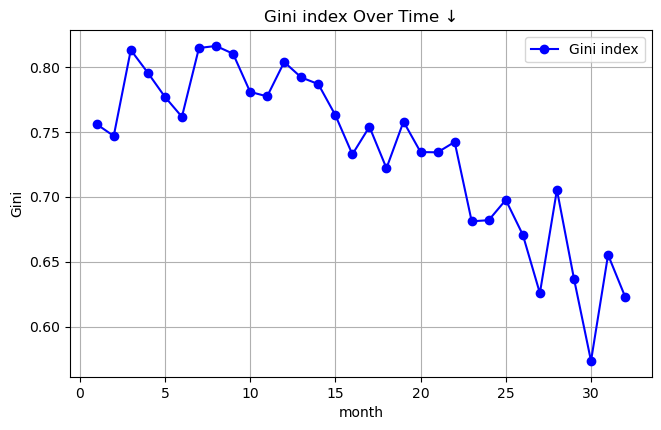

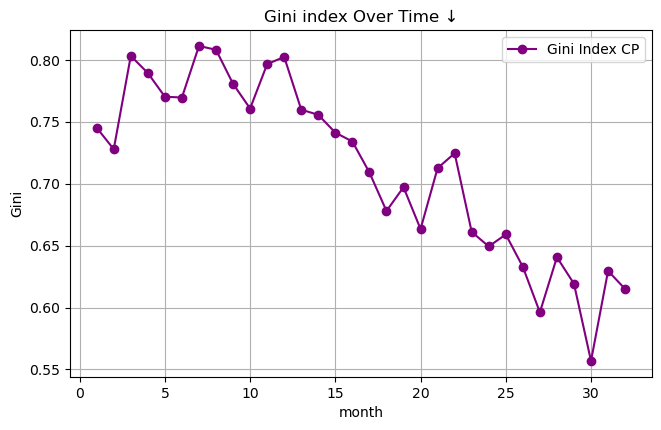

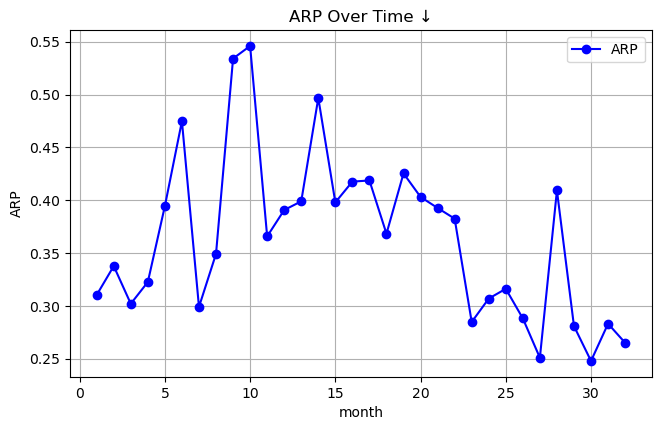

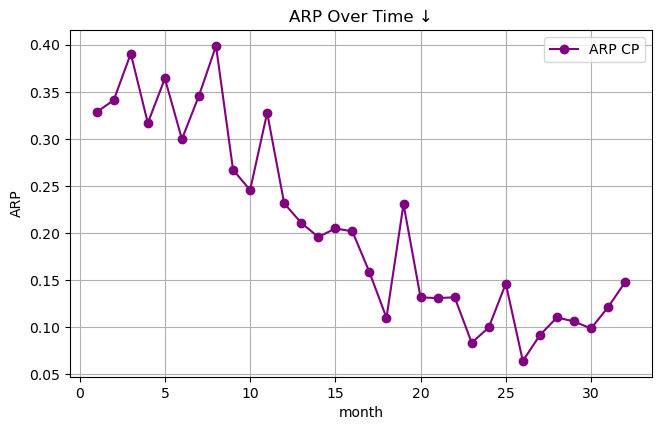

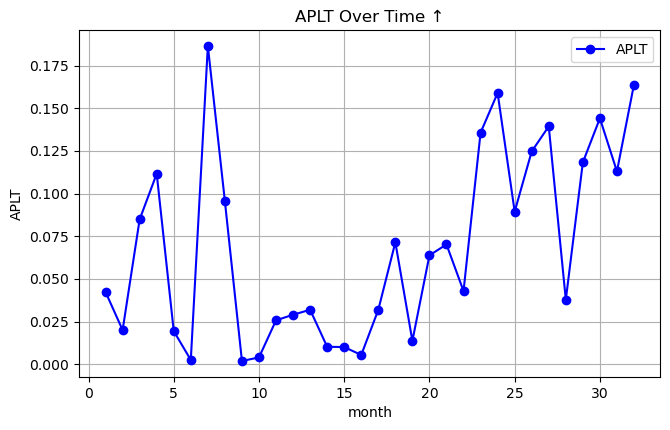

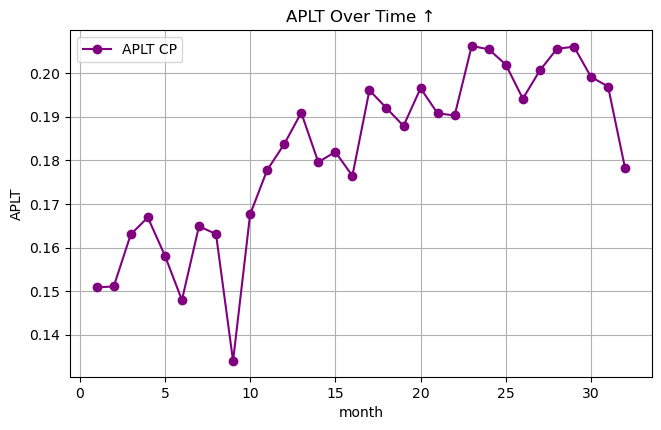

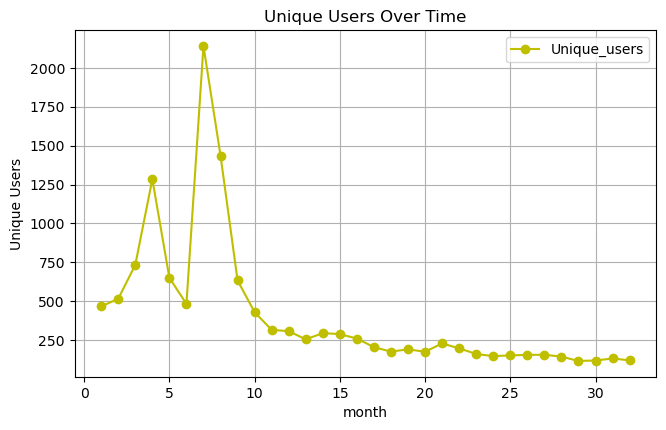

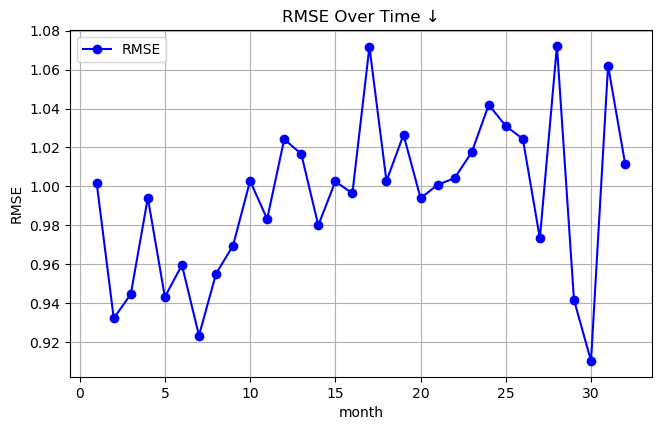

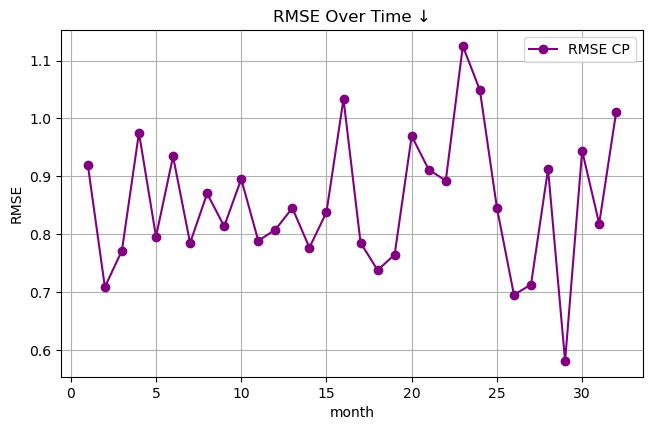

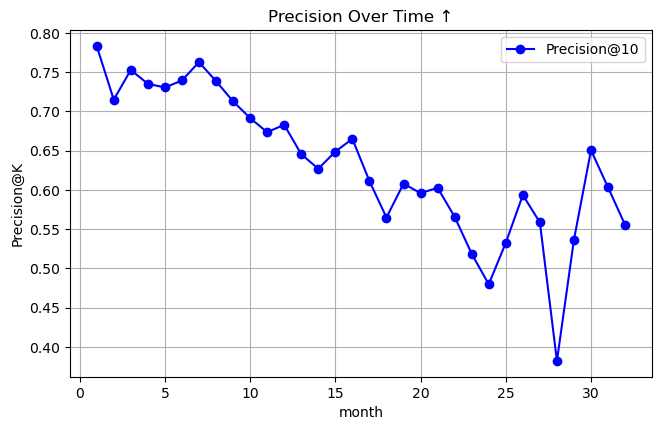

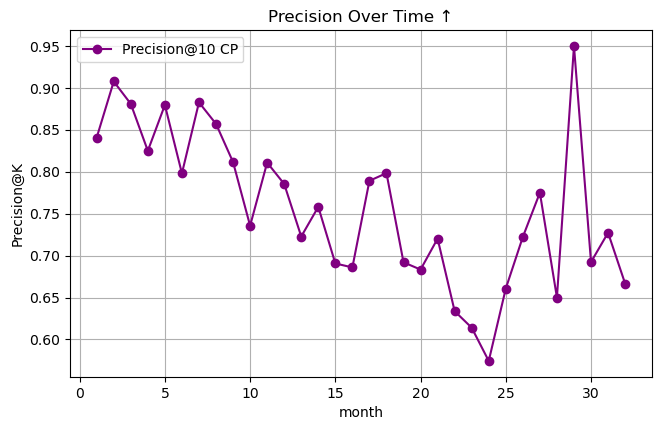

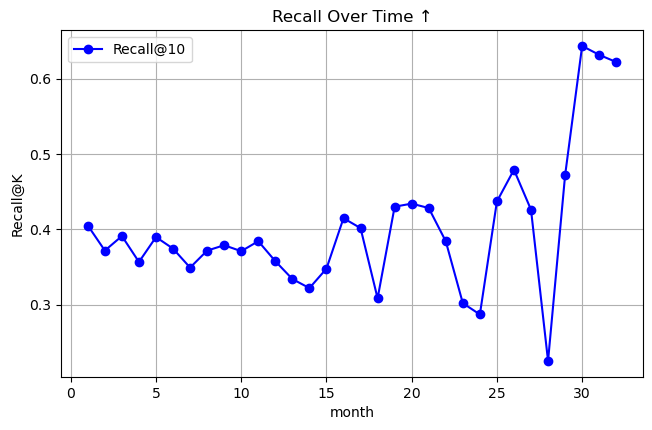

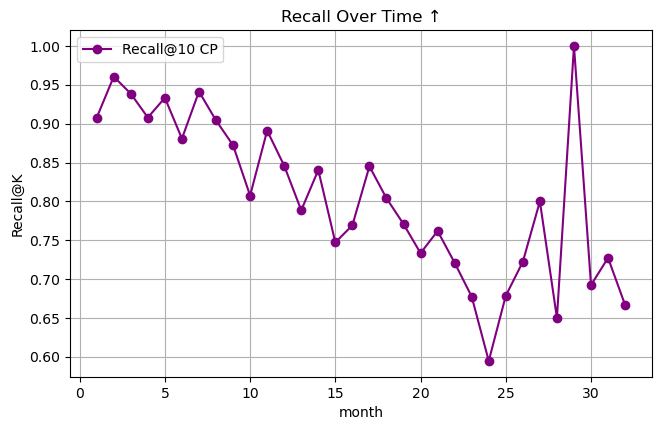

In [45]:
#Gini
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='Gini index')
plt.title('Gini index Over Time ↓')
plt.xlabel('month')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='Gini Index CP')
plt.title('Gini index Over Time ↓')
plt.xlabel('month')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()


#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='ARP')
plt.title('ARP Over Time ↓')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='ARP CP')
plt.title('ARP Over Time ↓')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='APLT')
plt.title('APLT Over Time ↑')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='APLT CP')
plt.title('APLT Over Time ↑')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, rmse_values, marker='o', color='b', label='RMSE')
plt.title('RMSE Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['rmse'], marker='o', color='purple', label='RMSE CP')
plt.title('RMSE Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

#Precision 
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, precision_values, marker='o', color='b', label='Precision@10')
plt.title('Precision Over Time ↑')
plt.xlabel('month')
plt.ylabel('Precision@K')
plt.grid(True)
plt.legend()
plt.show()

#Precision CP
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['precision@10'], marker='o', color='purple', label='Precision@10 CP')
plt.title('Precision Over Time ↑')
plt.xlabel('month')
plt.ylabel('Precision@K')
plt.grid(True)
plt.legend()
plt.show()

#Recall
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, recall_values, marker='o', color='b', label='Recall@10')
plt.title('Recall Over Time ↑')
plt.xlabel('month')
plt.ylabel('Recall@K')
plt.grid(True)
plt.legend()
plt.show()

#Recall CP
plt.figure(figsize=(7.5, 4.5))
plt.plot(results_df['month'], results_df['recall@10'], marker='o', color='purple', label='Recall@10 CP')
plt.title('Recall Over Time ↑')
plt.xlabel('month')
plt.ylabel('Recall@K')
plt.grid(True)
plt.legend()
plt.show()

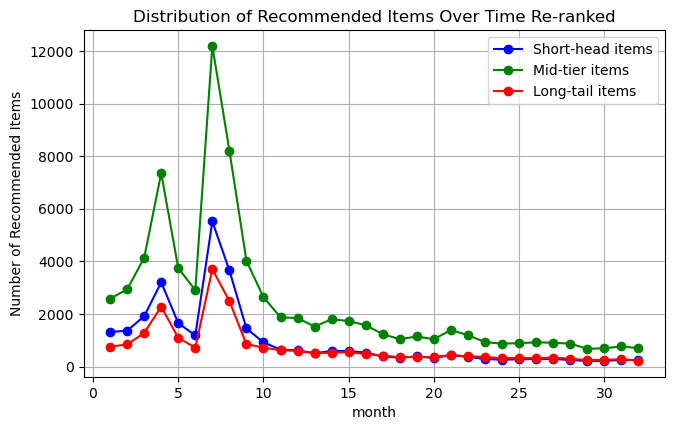

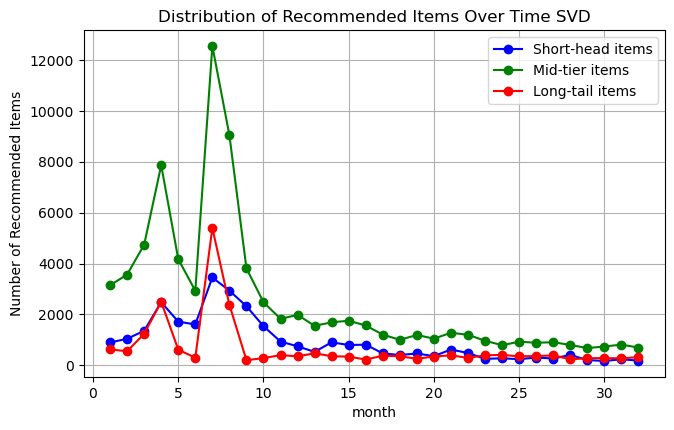

In [40]:
months = group_counts_df['month']
short_head_counts = group_counts_df['short_head_count']
mid_counts = group_counts_df['mid_count']
long_tail_counts = group_counts_df['long_tail_count']


plt.figure(figsize=(7.5, 4.5))

plt.plot(months, short_head_counts, marker='o', color='b', label='Short-head items')
plt.plot(months, mid_counts, marker='o', color='g', label='Mid-tier items')
plt.plot(months, long_tail_counts, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time Re-ranked')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()


months2 = group_counts_svd_df['month']
short_head_counts2 = group_counts_svd_df['short_head_count']
mid_counts2 = group_counts_svd_df['mid_count']
long_tail_counts2 = group_counts_svd_df['long_tail_count']

plt.figure(figsize=(7.5, 4.5))

plt.plot(months2, short_head_counts2, marker='o', color='b', label='Short-head items')
plt.plot(months2, mid_counts2, marker='o', color='g', label='Mid-tier items')
plt.plot(months2, long_tail_counts2, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time SVD')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()

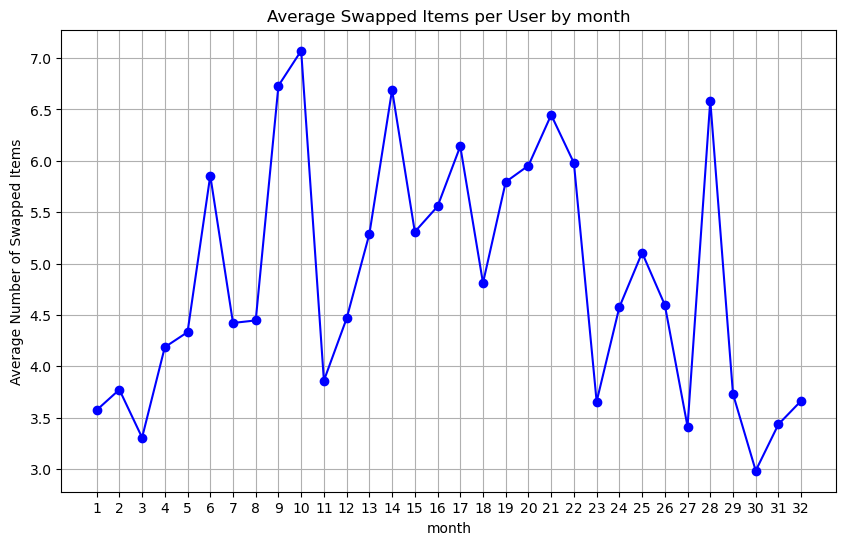

In [41]:
months = sorted(monthly_swapped_counts.keys())
avg_swaps = [monthly_swapped_counts[w] for w in months]

plt.figure(figsize=(10,6))
plt.plot(months, avg_swaps, marker='o', linestyle='-', color='b')
plt.title("Average Swapped Items per User by month")
plt.xlabel("month")
plt.ylabel("Average Number of Swapped Items")
plt.grid(True)
plt.xticks(months)
plt.show()


In [42]:
# Ensure the timestamp column is a datetime type
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

# Convert timestamps to monthly periods
monthly_periods = ratings['timestamp'].dt.to_period('M')

# Count the unique months
num_months = monthly_periods.nunique()
print("Number of months in the dataset:", num_months)

Number of months in the dataset: 35


In [53]:
precision_values = [result['precision@10'] for result in monthly_results]

cp_mean_precision = np.mean(results_df['precision@10'])
svd_mean_precision =np.mean(precision_values)

print(f"Mean precision for CP: {cp_mean_precision:.4f}")
print(f"Mean precision for SVD: {svd_mean_precision:.4f}")

Mean precision for CP: 0.7569
Mean precision for SVD: 0.6333


In [54]:
recall_values = [result['recall@10'] for result in monthly_results]

cp_mean_recall = np.mean(results_df['recall@10'])
svd_mean_recall =np.mean(recall_values)

print(f"Mean recall for CP: {cp_mean_recall:.4f}")
print(f"Mean recall for SVD: {svd_mean_recall:.4f}")

Mean recall for CP: 0.8057
Mean recall for SVD: 0.4012


In [58]:
rmse_values = [result['rmse'] for result in monthly_results]

cp_mean_rmse = np.mean(results_df['rmse'])
svd_mean_rmse =np.mean(rmse_values)

print(f"Mean rmse for CP: {cp_mean_rmse:.4f}")
print(f"Mean rmse for SVD: {svd_mean_rmse:.4f}")

Mean rmse for CP: 0.8540
Mean rmse for SVD: 0.9940


In [78]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Metric':       ['RMSE ↓',       'Precision@10 ↑',       'Recall@10 ↑'],
    'SVD':          [svd_mean_rmse, svd_mean_precision,  svd_mean_recall],
    'CP': [cp_mean_rmse, cp_mean_precision, cp_mean_recall]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


| Metric         |   SVD |    CP |
|----------------|-------|-------|
| RMSE ↓         | 0.994 | 0.854 |
| Precision@10 ↑ | 0.633 | 0.757 |
| Recall@10 ↑    | 0.401 | 0.806 |


In [ ]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

In [72]:
arp_values = [result['arp'] for result in monthly_results]

cp_mean_arp = np.mean(results_df['arp'])
svd_mean_arp =np.mean(arp_values)

print(f"Mean arp for CP: {cp_mean_arp:.4f}")
print(f"Mean arp for SVD: {svd_mean_arp:.4f}")

Mean arp for CP: 0.2073
Mean arp for SVD: 0.3645


In [73]:
aplt_values = [result['aplt'] for result in monthly_results]

cp_mean_aplt = np.mean(results_df['aplt'])
svd_mean_aplt =np.mean(aplt_values)

print(f"Mean aplt for CP: {cp_mean_aplt:.4f}")
print(f"Mean aplt for SVD: {svd_mean_aplt:.4f}")

Mean aplt for CP: 0.1814
Mean aplt for SVD: 0.0687


In [82]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Beyond Metric':       ['Gini-Index ↓',       'ARP ↓',       'APLT ↑'],
    'SVD':          [svd_mean_gini, svd_mean_arp,  svd_mean_aplt],
    'CP': [cp_mean_gini, cp_mean_arp, cp_mean_aplt]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


| Beyond Metric   |   SVD |    CP |
|-----------------|-------|-------|
| Gini-Index ↓    | 0.735 | 0.713 |
| ARP ↓           | 0.364 | 0.207 |
| APLT ↑          | 0.069 | 0.181 |


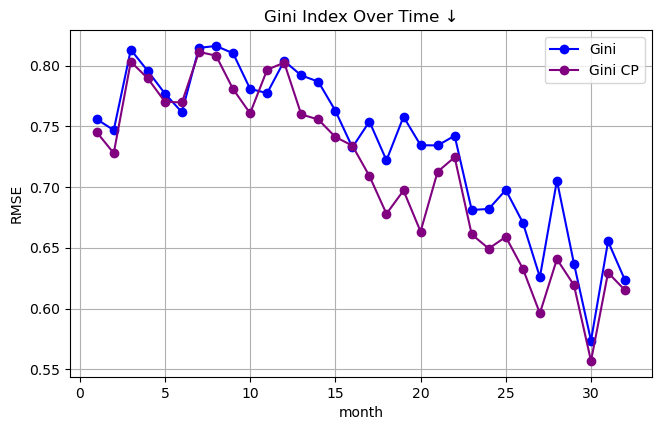

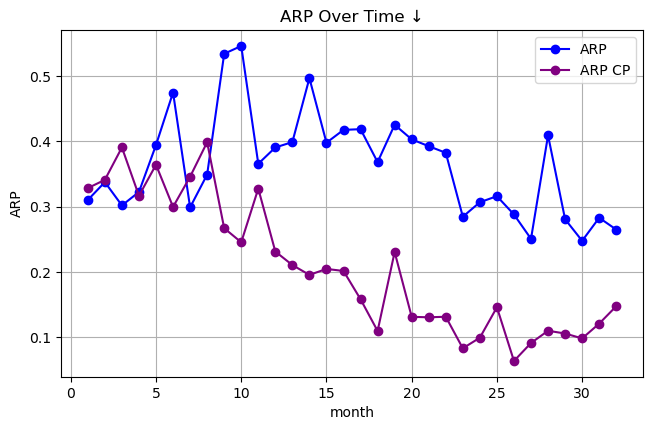

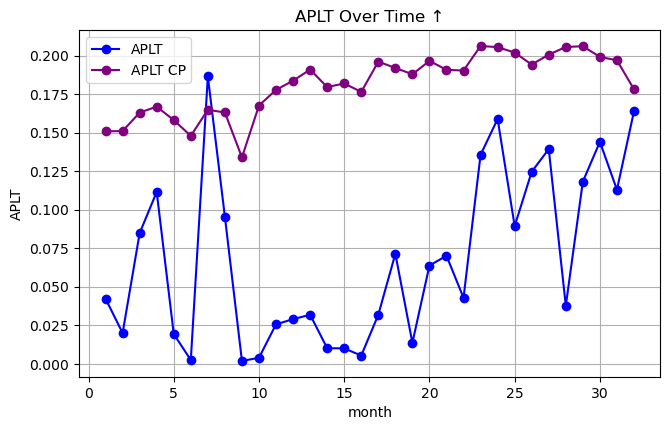

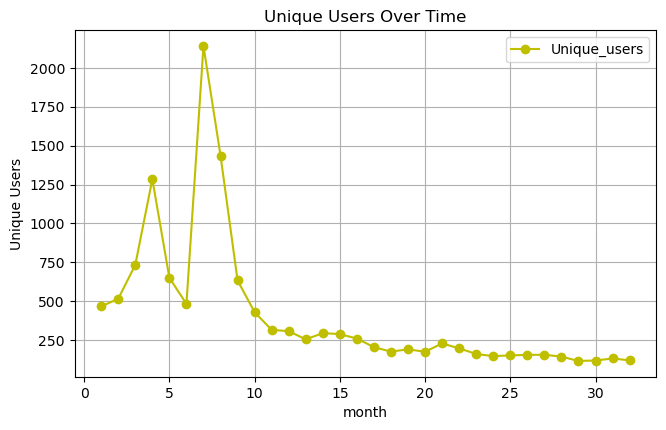

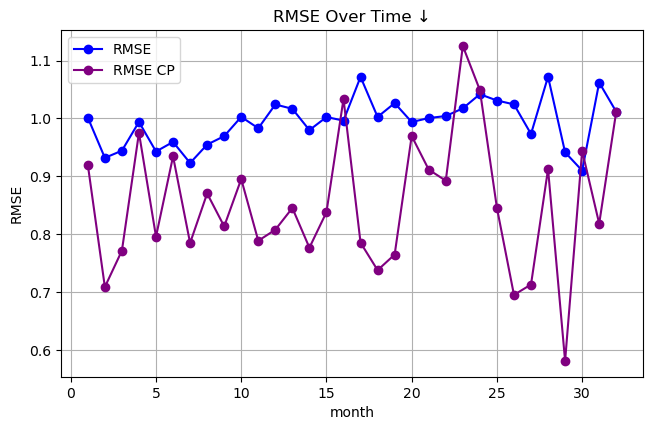

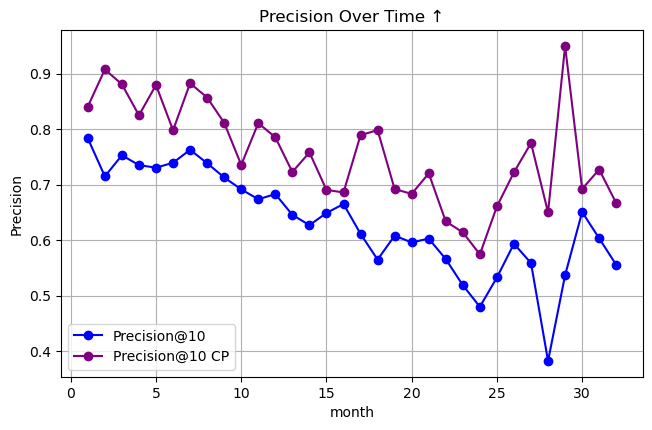

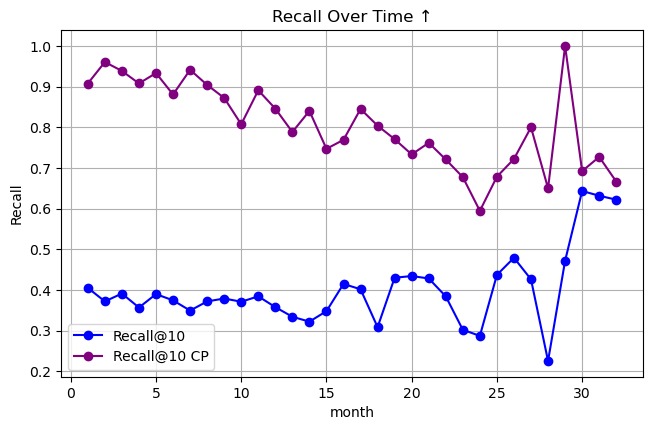

In [306]:
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='Gini')
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='Gini CP')
plt.title('Gini Index Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig('gini.png')
plt.show()

#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='ARP')
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='ARP CP')
plt.title('ARP Over Time ↓')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.savefig('arp.png')
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='APLT')
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='APLT CP')
plt.title('APLT Over Time ↑')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.savefig('aplt.png')
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, rmse_values, marker='o', color='b', label='RMSE')
plt.plot(results_df['month'], results_df['rmse'], marker='o', color='purple', label='RMSE CP')
plt.title('RMSE Over Time ↓')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig('rmse.png')
plt.show()

#Precision 
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, precision_values, marker='o', color='b', label='Precision@10')
plt.plot(results_df['month'], results_df['precision@10'], marker='o', color='purple', label='Precision@10 CP')
plt.title('Precision Over Time ↑')
plt.xlabel('month')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.savefig('precision.png')
plt.show()

#Recall
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, recall_values, marker='o', color='b', label='Recall@10')
plt.plot(results_df['month'], results_df['recall@10'], marker='o', color='purple', label='Recall@10 CP')
plt.title('Recall Over Time ↑')
plt.xlabel('month')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.savefig('recall.png')
plt.show()

In [253]:
top10_df = (
    recommendations_df
    # 1) Sort by month, then user, then rating descending 
    .sort_values(['month','userId','rating'], ascending=[True,True,False])
    # 2) For each (month, userId) pair, keep only the first 10 rows
    .groupby(['month','userId'], group_keys=False)
    .head(10)
    .reset_index(drop=True)
)
top10_df.head(15)

,userId,movieId,rating,month
0,5574,2019,4.967274,1
1,5574,2858,4.957594,1
2,5574,50,4.944291,1
3,5574,1252,4.919975,1
4,5574,2329,4.910045,1
5,5574,111,4.858311,1
6,5574,3307,4.837838,1
7,5574,1148,4.826513,1
8,5574,1260,4.822333,1
9,5574,296,4.813021,1


In [273]:
total_movies = set(ratings['movieId'].unique())

recommended_movies = set(top10_df['movieId'].unique())
recommended_movies2 = set(reranked_df['movieId'].unique())

coverage = len(recommended_movies) / len(total_movies)
coverage2 = len(recommended_movies2) / len(total_movies)
print(f"Coverage SVD: {coverage:.2%}\t" 
     f"Coverage CP: {coverage2:.2%}") 

Coverage SVD: 42.80%	Coverage CP: 55.40%


In [292]:
coverages = []

for month in sorted(top10_df['month'].unique()):
    dfm = top10_df[top10_df['month'] == month]
    rec_items = set(dfm['movieId'])
    total_items = ratings['movieId'].nunique()
    cov = len(rec_items) / total_items * 100
    print(f"Month {month} catalog coverage: {cov:.2f}%")
    coverages.append(cov)

# now compute the average
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage monthly catalog coverage: {avg_cov:.2f}%")
else:
    print("No months to average.")


Month 1 catalog coverage: 6.21%
Month 2 catalog coverage: 6.96%
Month 3 catalog coverage: 7.10%
Month 4 catalog coverage: 10.60%
Month 5 catalog coverage: 6.69%
Month 6 catalog coverage: 4.56%
Month 7 catalog coverage: 13.38%
Month 8 catalog coverage: 10.12%
Month 9 catalog coverage: 4.75%
Month 10 catalog coverage: 4.05%
Month 11 catalog coverage: 3.32%
Month 12 catalog coverage: 3.83%
Month 13 catalog coverage: 4.24%
Month 14 catalog coverage: 4.13%
Month 15 catalog coverage: 4.48%
Month 16 catalog coverage: 3.89%
Month 17 catalog coverage: 5.34%
Month 18 catalog coverage: 6.18%
Month 19 catalog coverage: 4.51%
Month 20 catalog coverage: 6.10%
Month 21 catalog coverage: 5.59%
Month 22 catalog coverage: 4.59%
Month 23 catalog coverage: 6.48%
Month 24 catalog coverage: 6.42%
Month 25 catalog coverage: 6.50%
Month 26 catalog coverage: 6.83%
Month 27 catalog coverage: 7.20%
Month 28 catalog coverage: 4.88%
Month 29 catalog coverage: 6.23%
Month 30 catalog coverage: 6.88%
Month 31 catalog

In [294]:
coverages = []

for month in sorted(reranked_df['month'].unique()):
    dfm = reranked_df[reranked_df['month'] == month]
    rec_items = set(dfm['movieId'])
    total_items = ratings['movieId'].nunique()
    cov = len(rec_items) / total_items * 100
    print(f"Month {month} catalog coverage: {cov:.2f}%")
    coverages.append(cov)

# now compute the average
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage monthly catalog coverage: {avg_cov:.2f}%")
else:
    print("No months to average.")


Month 1 catalog coverage: 6.72%
Month 2 catalog coverage: 7.96%
Month 3 catalog coverage: 7.42%
Month 4 catalog coverage: 10.82%
Month 5 catalog coverage: 7.72%
Month 6 catalog coverage: 6.91%
Month 7 catalog coverage: 13.90%
Month 8 catalog coverage: 10.66%
Month 9 catalog coverage: 7.61%
Month 10 catalog coverage: 7.34%
Month 11 catalog coverage: 5.34%
Month 12 catalog coverage: 6.31%
Month 13 catalog coverage: 6.23%
Month 14 catalog coverage: 7.02%
Month 15 catalog coverage: 7.02%
Month 16 catalog coverage: 6.48%
Month 17 catalog coverage: 7.83%
Month 18 catalog coverage: 7.69%
Month 19 catalog coverage: 6.69%
Month 20 catalog coverage: 7.61%
Month 21 catalog coverage: 8.58%
Month 22 catalog coverage: 6.85%
Month 23 catalog coverage: 7.02%
Month 24 catalog coverage: 7.10%
Month 25 catalog coverage: 7.47%
Month 26 catalog coverage: 7.56%
Month 27 catalog coverage: 7.18%
Month 28 catalog coverage: 6.93%
Month 29 catalog coverage: 6.48%
Month 30 catalog coverage: 6.61%
Month 31 catalog

In [287]:
# 1) Build a DataFrame of (userId, movieId) from your train_test_sets
test_rows = [
    (user, movie)
    for _, testset, _, _ in train_test_sets
    for user, movie, _ in testset
]
test_df = pd.DataFrame(test_rows, columns=['userId', 'movieId']).drop_duplicates()

# 2) Merge with your top-10 recommendation DataFrame
merged = (
    top10_df
    .merge(test_df,
           on=['userId','movieId'],
           how='left',
           indicator=True)
)

# 3) Calculate Test‐coverage@10
hits = (merged['_merge'] == 'both').sum()
total_slots = len(top10_df)  # should be n_users * 10
coverage_at_10 = hits / total_slots

print(f"Test‐coverage@10 SVD: {coverage_at_10:.2%}")



Test‐coverage@10 SVD: 10.30%


In [286]:
# 1) Build a DataFrame of (userId, movieId) from your train_test_sets
test_rows = [
    (user, movie)
    for _, testset, _, _ in train_test_sets
    for user, movie, _ in testset
]
test_df = pd.DataFrame(test_rows, columns=['userId', 'movieId']).drop_duplicates()

# 2) Merge with your top-10 recommendation DataFrame
merged = (
    reranked_df
    .merge(test_df,
           on=['userId','movieId'],
           how='left',
           indicator=True)
)

# 3) Calculate Test‐coverage@10
hits = (merged['_merge'] == 'both').sum()
total_slots = len(top10_df)  # should be n_users * 10
coverage_at_10 = hits / total_slots

print(f"Test‐coverage@10 CP: {coverage_at_10:.2%}")


Test‐coverage@10 CP: 8.77%


In [296]:
# 1) Build a list of all months in your recommendations
months = sorted(top10_df['month'].unique())

# 2) Map each month to its testset
#    (zip relies on the fact that train_test_sets is in the same order)
month_to_test = {
    month: testset
    for month, (_, testset, *_rest) in zip(months, train_test_sets)
}

coverages = []

for month in months:
    # 3) Extract that month’s top-10 recs
    dfm = top10_df[top10_df['month'] == month][['userId','movieId']]

    # 4) Build a DataFrame of unique (userId, movieId) for that month’s test
    test_rows = [
        (u, m)
        for u, m, _ in month_to_test[month]
    ]
    test_df_month = (
        pd.DataFrame(test_rows, columns=['userId','movieId'])
          .drop_duplicates()
    )

    # 5) Merge & flag which slots hit
    merged = dfm.merge(
        test_df_month,
        on=['userId','movieId'],
        how='left',
        indicator=True
    )
    hits        = (merged['_merge'] == 'both').sum()
    total_slots = len(dfm)           # should be n_users_for_month × 10
    cov_pct     = hits / total_slots * 100

    print(f"Month {month} test‐coverage@10: {cov_pct:.2f}%")
    coverages.append(cov_pct)

# 6) Average across months
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage test‐coverage@10 over {len(coverages)} months for SVD: {avg_cov:.2f}%")
else:
    print("No months to process.")


Month 1 test‐coverage@10: 3.15%
Month 2 test‐coverage@10: 3.86%
Month 3 test‐coverage@10: 3.59%
Month 4 test‐coverage@10: 3.22%
Month 5 test‐coverage@10: 5.28%
Month 6 test‐coverage@10: 5.79%
Month 7 test‐coverage@10: 4.44%
Month 8 test‐coverage@10: 4.12%
Month 9 test‐coverage@10: 5.94%
Month 10 test‐coverage@10: 6.22%
Month 11 test‐coverage@10: 10.16%
Month 12 test‐coverage@10: 8.76%
Month 13 test‐coverage@10: 6.93%
Month 14 test‐coverage@10: 7.52%
Month 15 test‐coverage@10: 5.73%
Month 16 test‐coverage@10: 6.14%
Month 17 test‐coverage@10: 6.32%
Month 18 test‐coverage@10: 5.03%
Month 19 test‐coverage@10: 4.68%
Month 20 test‐coverage@10: 4.20%
Month 21 test‐coverage@10: 2.59%
Month 22 test‐coverage@10: 3.67%
Month 23 test‐coverage@10: 2.38%
Month 24 test‐coverage@10: 3.22%
Month 25 test‐coverage@10: 2.65%
Month 26 test‐coverage@10: 1.75%
Month 27 test‐coverage@10: 1.61%
Month 28 test‐coverage@10: 1.82%
Month 29 test‐coverage@10: 0.70%
Month 30 test‐coverage@10: 1.69%
Month 31 test‐cove

In [297]:
# 1) Build a list of all months in your recommendations
months = sorted(reranked_df['month'].unique())

# 2) Map each month to its testset
#    (zip relies on the fact that train_test_sets is in the same order)
month_to_test = {
    month: testset
    for month, (_, testset, *_rest) in zip(months, train_test_sets)
}

coverages = []

for month in months:
    # 3) Extract that month’s top-10 recs
    dfm = reranked_df[reranked_df['month'] == month][['userId','movieId']]

    # 4) Build a DataFrame of unique (userId, movieId) for that month’s test
    test_rows = [
        (u, m)
        for u, m, _ in month_to_test[month]
    ]
    test_df_month = (
        pd.DataFrame(test_rows, columns=['userId','movieId'])
          .drop_duplicates()
    )

    # 5) Merge & flag which slots hit
    merged = dfm.merge(
        test_df_month,
        on=['userId','movieId'],
        how='left',
        indicator=True
    )
    hits        = (merged['_merge'] == 'both').sum()
    total_slots = len(dfm)           # should be n_users_for_month × 10
    cov_pct     = hits / total_slots * 100

    print(f"Month {month} test‐coverage@10: {cov_pct:.2f}%")
    coverages.append(cov_pct)

# 6) Average across months
if coverages:
    avg_cov = sum(coverages) / len(coverages)
    print(f"\nAverage test‐coverage@10 over {len(coverages)} months for CP: {avg_cov:.2f}%")
else:
    print("No months to process.")


Month 1 test‐coverage@10: 2.85%
Month 2 test‐coverage@10: 3.42%
Month 3 test‐coverage@10: 3.37%
Month 4 test‐coverage@10: 2.75%
Month 5 test‐coverage@10: 4.11%
Month 6 test‐coverage@10: 4.81%
Month 7 test‐coverage@10: 4.03%
Month 8 test‐coverage@10: 3.53%
Month 9 test‐coverage@10: 5.48%
Month 10 test‐coverage@10: 6.43%
Month 11 test‐coverage@10: 9.33%
Month 12 test‐coverage@10: 8.53%
Month 13 test‐coverage@10: 6.54%
Month 14 test‐coverage@10: 7.41%
Month 15 test‐coverage@10: 4.86%
Month 16 test‐coverage@10: 5.17%
Month 17 test‐coverage@10: 5.74%
Month 18 test‐coverage@10: 4.00%
Month 19 test‐coverage@10: 4.05%
Month 20 test‐coverage@10: 4.02%
Month 21 test‐coverage@10: 2.46%
Month 22 test‐coverage@10: 3.16%
Month 23 test‐coverage@10: 3.12%
Month 24 test‐coverage@10: 3.22%
Month 25 test‐coverage@10: 2.45%
Month 26 test‐coverage@10: 1.36%
Month 27 test‐coverage@10: 1.48%
Month 28 test‐coverage@10: 1.68%
Month 29 test‐coverage@10: 1.13%
Month 30 test‐coverage@10: 1.36%
Month 31 test‐cover

In [299]:
# === OVERALL USER OVERLAP ===

# Collect all raw user‐IDs seen in any train split
train_users = set()
for trainset, _, *_ in train_test_sets:
    train_users |= { trainset.to_raw_uid(uid) for uid in trainset.all_users() }

# Collect all user‐IDs seen in any test split
test_users = set()
for _, testset, *_ in train_test_sets:
    test_users |= { u for u, _, _ in testset }

overlap = train_users & test_users

print(f"Overall train users: {len(train_users)}")
print(f"Overall test  users: {len(test_users)}")
print(f"Overlap users     : {len(overlap)} "
      f"({len(overlap)/len(test_users)*100:.2f}% of test users)")

# === PER-MONTH USER OVERLAP ===

# If you want to see it month by month:
months = sorted(top10_df['month'].unique())
for month, (trainset, testset, *_ ) in zip(months, train_test_sets):
    train_u = { trainset.to_raw_uid(uid) for uid in trainset.all_users() }
    test_u  = { u for u, _, _ in testset }
    ov      = train_u & test_u
    pct     = len(ov) / len(test_u) * 100 if test_u else 0.0
    print(f"Month {month}: {len(ov)} overlapping users "
          f"({pct:.2f}% of that month’s test users)")


Overall train users: 6040
Overall test  users: 1682
Overlap users     : 1682 (100.00% of test users)
Month 1: 135 overlapping users (100.00% of that month’s test users)
Month 2: 186 overlapping users (100.00% of that month’s test users)
Month 3: 251 overlapping users (100.00% of that month’s test users)
Month 4: 372 overlapping users (100.00% of that month’s test users)
Month 5: 320 overlapping users (100.00% of that month’s test users)
Month 6: 273 overlapping users (100.00% of that month’s test users)
Month 7: 740 overlapping users (100.00% of that month’s test users)
Month 8: 629 overlapping users (100.00% of that month’s test users)
Month 9: 443 overlapping users (100.00% of that month’s test users)
Month 10: 342 overlapping users (100.00% of that month’s test users)
Month 11: 268 overlapping users (100.00% of that month’s test users)
Month 12: 265 overlapping users (100.00% of that month’s test users)
Month 13: 214 overlapping users (100.00% of that month’s test users)
Month 14: 2

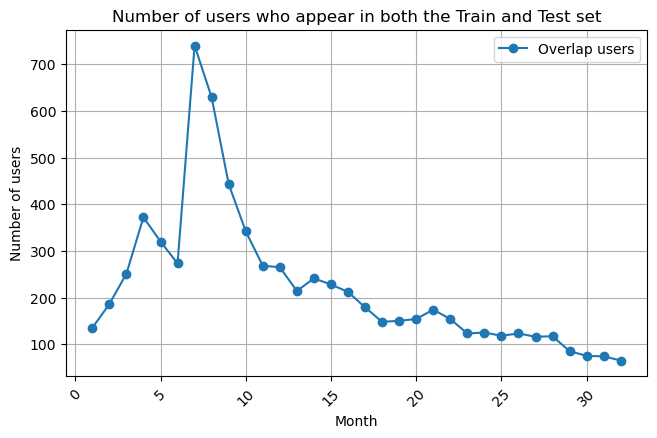

In [305]:
# 1) Gather per-month counts
months       = sorted(top10_df['month'].unique())
train_counts = []
test_counts  = []
overlap_counts = []

for month, (trainset, testset, *_) in zip(months, train_test_sets):
    # users seen in training (Surprise trainset)
    train_users = {trainset.to_raw_uid(uid) for uid in trainset.all_users()}
    # users in that month's test
    test_users  = {u for u, _, _ in testset}
    overlap     = train_users & test_users

    train_counts.append(len(train_users))
    test_counts.append(len(test_users))
    overlap_counts.append(len(overlap))

# 2) Plot all three series on one chart
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, overlap_counts, marker='o', label='Overlap users')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of users')
plt.title('Number of users who appear in both the Train and Test set')
plt.legend()
plt.grid(True)
plt.show()